In [1]:
import tensorflow as tf
from sklearn.model_selection import KFold
import foolbox as fb
#import torchvision.models as models
import eagerpy as ep
from foolbox import TensorFlowModel
from foolbox import PyTorchModel, accuracy, samples
import foolbox.attacks as fa
from foolbox.attacks import LinfPGD, BoundaryAttack, FGSM, LinfDeepFoolAttack
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.metrics import pairwise_distances

In [2]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

In [3]:
kf = KFold(n_splits = 5)

In [4]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10)
])


In [5]:
kf.split(x_train)

<generator object _BaseKFold.split at 0x000002ED30248DC8>

In [6]:
predictions = model(x_train[:5]).numpy()
predictions

array([[-0.17005411, -0.32760033,  0.22867246, -0.21937375, -0.54158604,
        -0.25031388,  0.3240782 , -0.23068757,  0.15806861,  0.15695848],
       [ 0.08360546, -0.5014346 ,  0.03782161, -0.7937428 , -0.26227012,
        -0.4272241 ,  0.67331904, -0.28355664,  0.04786408, -0.3221184 ],
       [-0.22537982, -0.00689497, -0.04628288, -0.05203488, -0.19974384,
        -0.23665117,  0.14445148, -0.06544915,  0.13918851,  0.27841458],
       [-0.32396686,  0.19062115,  0.02647322,  0.3297082 , -0.17398706,
         0.3161718 ,  0.07542458, -0.41461152, -0.19816001,  0.2020305 ],
       [-0.08555889, -0.04723964, -0.36583516, -0.77493674, -0.8409485 ,
        -0.13579682,  0.20962015, -0.06399634,  0.15784231,  0.10699758]],
      dtype=float32)

In [7]:
#tf.nn.softmax(predictions).numpy()

In [8]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [9]:
#loss_fn(y_train[:5], predictions).numpy()

In [10]:
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

In [11]:
for train_index, val_index in kf.split(x_train):
    x_trainNew, x_validate = x_train[train_index], x_train[val_index]
    y_trainNew, y_validate = y_train[train_index], y_train[val_index]
    
    model.fit(x_trainNew, y_trainNew, epochs=5, validation_data = (x_validate, y_validate), batch_size = 50)
    

Epoch 1/5
960/960 [==============================] - 2s 2ms/step - loss: 0.3530 - accuracy: 0.8980 - val_loss: 0.1765 - val_accuracy: 0.9488
Epoch 2/5
960/960 [==============================] - 1s 2ms/step - loss: 0.1708 - accuracy: 0.9494 - val_loss: 0.1299 - val_accuracy: 0.9627
Epoch 3/5
960/960 [==============================] - 1s 1ms/step - loss: 0.1292 - accuracy: 0.9624 - val_loss: 0.1072 - val_accuracy: 0.9697
Epoch 4/5
960/960 [==============================] - 1s 1ms/step - loss: 0.1055 - accuracy: 0.9683 - val_loss: 0.0984 - val_accuracy: 0.9717
Epoch 5/5
960/960 [==============================] - 1s 2ms/step - loss: 0.0902 - accuracy: 0.9726 - val_loss: 0.0893 - val_accuracy: 0.9724
Epoch 1/5
960/960 [==============================] - 1s 1ms/step - loss: 0.0862 - accuracy: 0.9734 - val_loss: 0.0562 - val_accuracy: 0.9820
Epoch 2/5
960/960 [==============================] - 1s 1ms/step - loss: 0.0720 - accuracy: 0.9781 - val_loss: 0.0591 - val_accuracy: 0.9813
Epoch 3/5
960

In [12]:
fmodel = fb.TensorFlowModel(model, bounds=(0,1))

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


In [13]:
images, labels = ep.astensors(*samples(fmodel, dataset='mnist', batchsize=1))
image_arr = np.array(images)

In [14]:
print(fb.accuracy(fmodel, images, labels))

1.0


In [15]:
attacks = [
        fb.attacks.FGSM(),
        fb.attacks.PGD(steps = 500),
        #fa.LinfBasicIterativeAttack(),
        #fa.LinfAdditiveUniformNoiseAttack(),
        fb.attacks.L2DeepFoolAttack(steps = 500)
    ]

epsilons = [
        0.0,
        #0.0005,
        #0.001,
        #0.0015,
        #0.002,
        #0.003,
        0.005,
        #0.01,
        #0.02,
        0.03,
        0.1,
        #0.3,
        0.5,
        1.0
    ]

In [41]:
attack_success = np.zeros((len(attacks), len(epsilons), len(images)), dtype=np.bool)

adversarial_images = []
time_of_attack = []
t0 = 0
t1 = 0
totsuccess = []
eachtot = []
successful = 0

#L2 Calculations
individualL2 = []


for i, attack in enumerate(attacks):
    t0 = time.process_time()
    advs, _, success = attack(fmodel, images, labels, epsilons=epsilons)
    t1 = time.process_time()
    time_of_attack.append(t1-t0) #First FGSM, then LinfPGD, then LinfDeepFoolAttack
    
    
    adversarial_images.append(advs)
    
    #for aval in success:
    #    successful = 0
    #    for aboolean in aval:
    #        aboolean1 = np.array(aboolean)
    #        if aboolean1:
    #            successful += 1
    #            eachtot.append(successful)
    #totsuccess.append(eachtot)
    #eachtot = []
        

    #Start calculating the average L2 values
    #newadvs = np.array(advs)
    #for epsilonsindex in range(len(epsilons)):
    #    newadvs1 = newadvs[epsilonsindex]
    #    metrics = []
    #    for i in range(len(image_arr)):
    #        metrics1 = []
    #        thing = pairwise_distances(np.squeeze(image_arr[i]), np.squeeze(newadvs1[i]), metric='l2')
    #        for j in range(len(image_arr[i])):
    #            metrics1.append(thing[j][j])
    #        metrics.append(np.average(metrics1))
    #individualL2.append(np.average(metrics))
    #L2.append(individual)
    
    assert success.shape == (len(epsilons), len(images))
    success_ = success.numpy()
    assert success_.dtype == np.bool
    attack_success[i] = success_
    
    
    
    print(attack)
    print("  ", 1.0 - success_.mean(axis=-1).round(4))
    #print(totsuccess)

LinfFastGradientAttack(rel_stepsize=1.0, abs_stepsize=None, steps=1, random_start=False)
   [1.   0.95 0.8  0.1  0.   0.  ]
LinfProjectedGradientDescentAttack(rel_stepsize=0.03333333333333333, abs_stepsize=None, steps=500, random_start=True)
   [1.   0.95 0.74 0.01 0.   0.  ]
L2DeepFoolAttack(steps=500, candidates=10, overshoot=0.02, loss=logits)
   [1.   1.   1.   0.95 0.8  0.25]


In [42]:
#for the 100 examples
fmodel = fb.TensorFlowModel(model, bounds=(0,1))
images, labels =ep.astensors(*samples(fmodel, dataset='mnist', batchsize=100))
test_lables=labels.numpy()

In [43]:
def Plot__(attack):
    images__=[image.numpy() for image in adversarial_images[attack]]


    # for i in images__:
    #     plt.imshow(i.squeeze(), cmap="gray")
    #     plt.axis('off')

    #     print(np.argmax(model.predict(i)))
    #     plt.show()

    for i in range(len(images__)):

        truth = labels[0]
        prediction = np.argmax(model.predict(images__[i]))
        plt.subplot(3, 2,1+i)
        plt.axis('off')
        color='green' if truth == prediction else 'red'
        plt.text(40, 20, "Truth:        {0}\nPrediction: {1}\nEpsilon: {2}".format(truth, prediction, epsilons[i]), 
                fontsize=12, color=color)
        plt.imshow(images__[i].squeeze(),  cmap="gray")

TypeError: Invalid shape (100, 28, 28) for image data

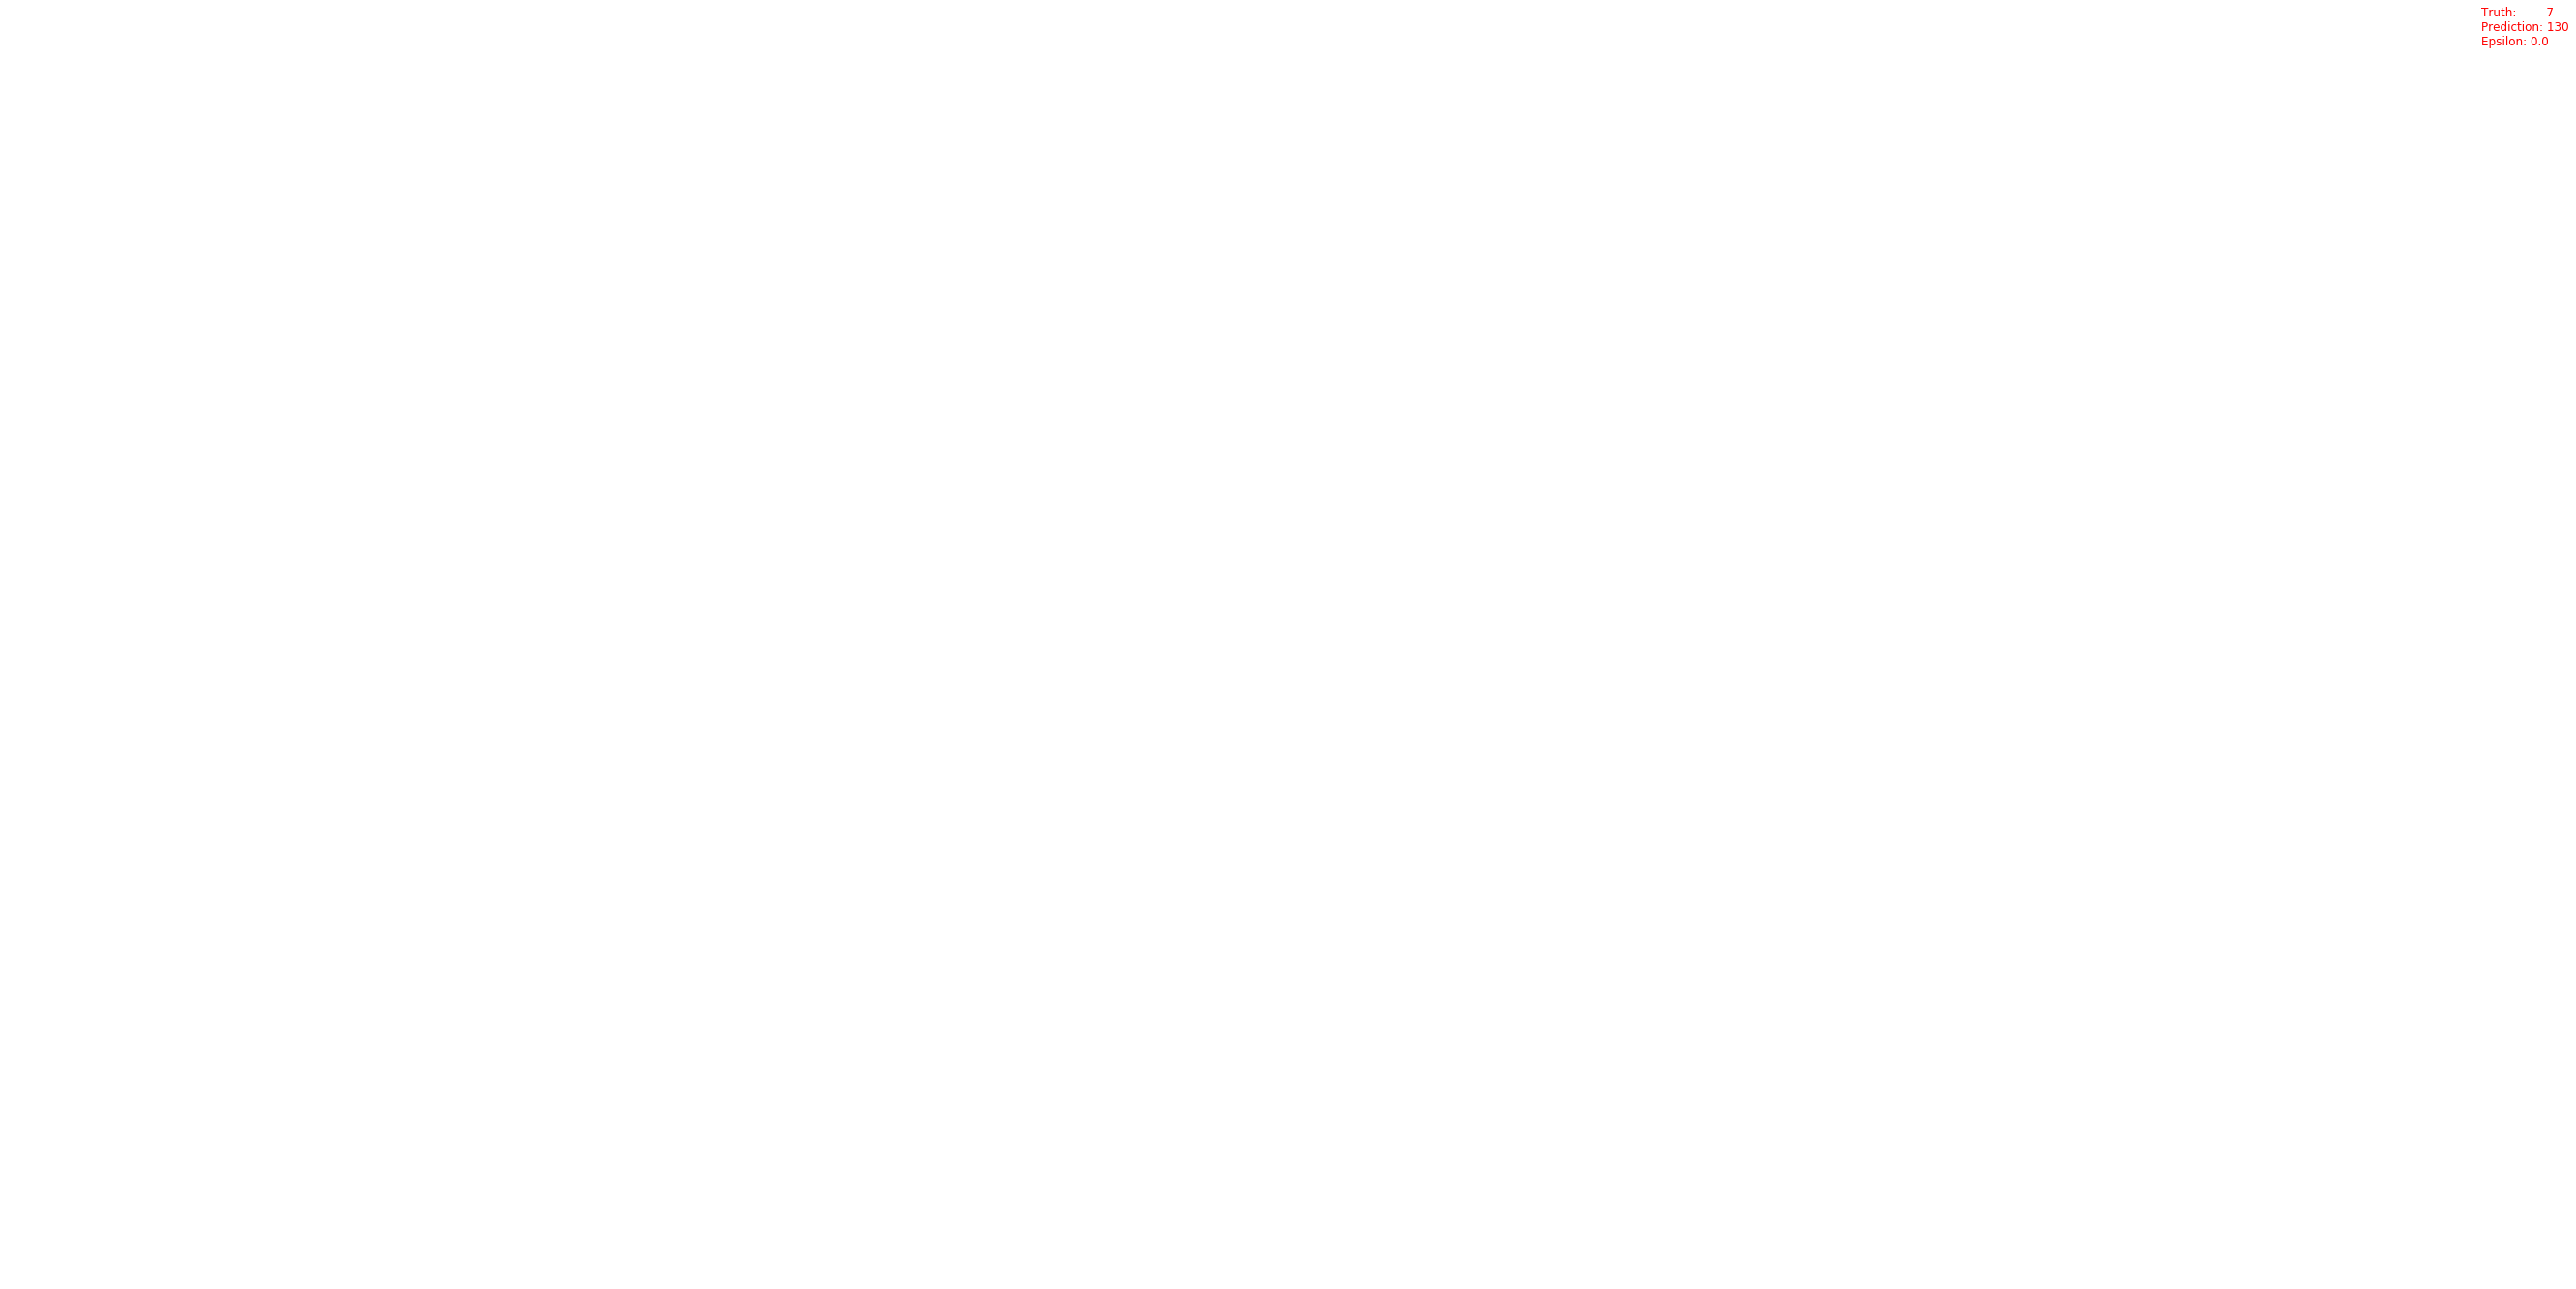

In [44]:
Plot__(0)

In [ ]:
Plot__(1)

In [ ]:
Plot__(2)

In [18]:
attacks1 = [
    fb.attacks.FGSM(),
    fb.attacks.PGD(steps=500),
    fb.attacks.L2DeepFoolAttack(steps=500)
    ]

epsilons1 =[0.0,
            0.025,
            0.05,
            0.1]

In [19]:
time_of_attack = []
L2 = []
success_adv = np.zeros((len(attacks1),len(epsilons1)))
attack_success_100 = np.zeros((len(attacks1), len(epsilons1), len(images)), dtype=np.bool)

adversarial_ml_images = []

for i, attack_100 in enumerate(attacks1):
    
    t0=time.time()
    advs1, _, success1 = attack(fmodel, images, labels, epsilons=epsilons1)
    t1=time.time()
    time_of_attack.append(t1-t0)
    adversarial_ml_images.append(advs1)

    assert success1.shape == (len(epsilons1), len(images))
    success_100 = success1.numpy()
    assert success_100.dtype == np.bool
    attack_success_100[i] = success_100
    print(attack_100)
    success_adv[i]= values=success_100.mean(axis=-1).round(2)
    print("  ",  success_adv[i])

LinfFastGradientAttack(rel_stepsize=1.0, abs_stepsize=None, steps=1, random_start=False)
   [0.   0.   0.   0.05]
LinfProjectedGradientDescentAttack(rel_stepsize=0.03333333333333333, abs_stepsize=None, steps=500, random_start=True)
   [0.   0.   0.   0.05]
L2DeepFoolAttack(steps=500, candidates=10, overshoot=0.02, loss=logits)
   [0.   0.   0.   0.05]


In [20]:
def L2_and_plot(attack_type,epsilon_index):
   
    images__=[image.numpy() for image in adversarial_ml_images[attack_type][epsilon_index]]
    images_=images.numpy()
    L2_dist=[]
    fig = plt.figure(figsize=(50, 50))
    for i in range(len(images__)):

        truth = labels[i]
        prediction = np.argmax(model.predict(images__[i].reshape((1,28,28))))
        plt.subplot(25, 5,1+i)
        plt.axis('off')
        if truth == prediction:
            color = 'green'
        else:
            color = 'red'
        plt.text(40, 25, "Actual: {0}\nPrediction: {1}\nEpsilon: {2}".format(truth, prediction, epsilons1[epsilon_index]), fontsize=25, color=color)
        L2_dist.append( (np.sum((images_[i].squeeze()-images__[i].squeeze())**2))**(0.5))  #-commpute the L2 norm diffrence 
        plt.imshow(images__[i].squeeze(),  cmap="gray")
    
    L2.append(np.average(L2_dist))    #- take the average

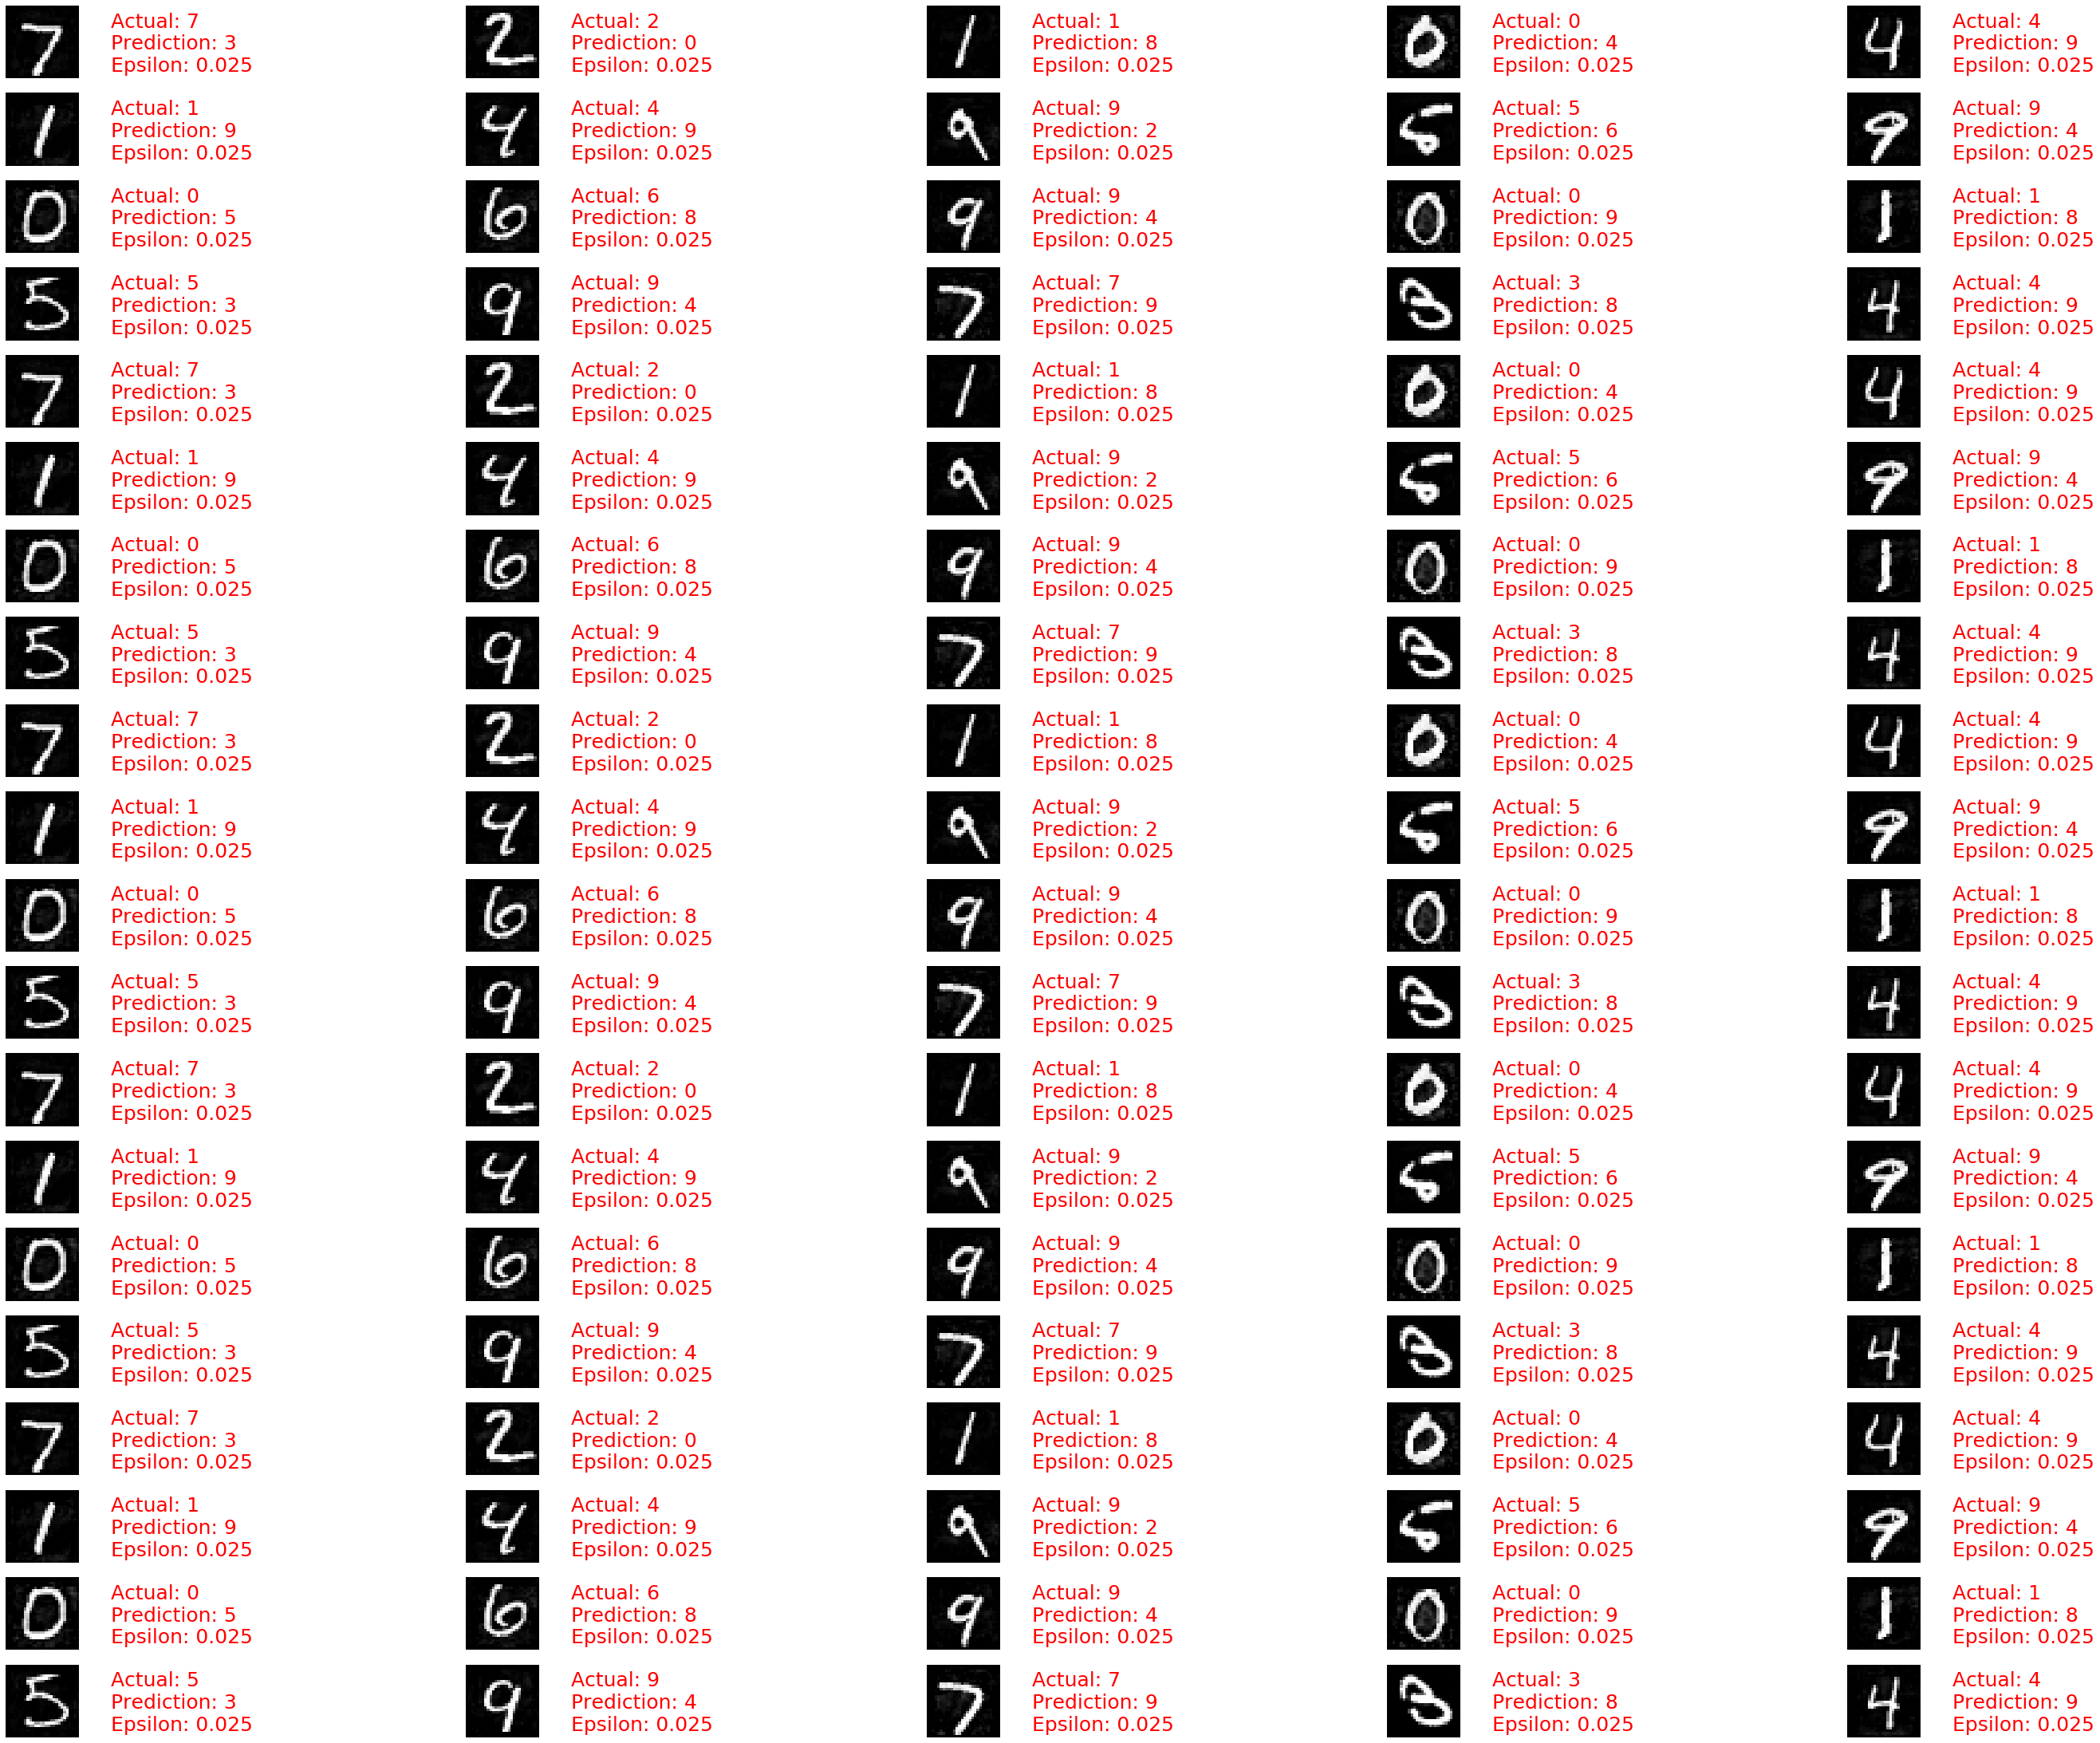

In [21]:
L2_and_plot(0,1)

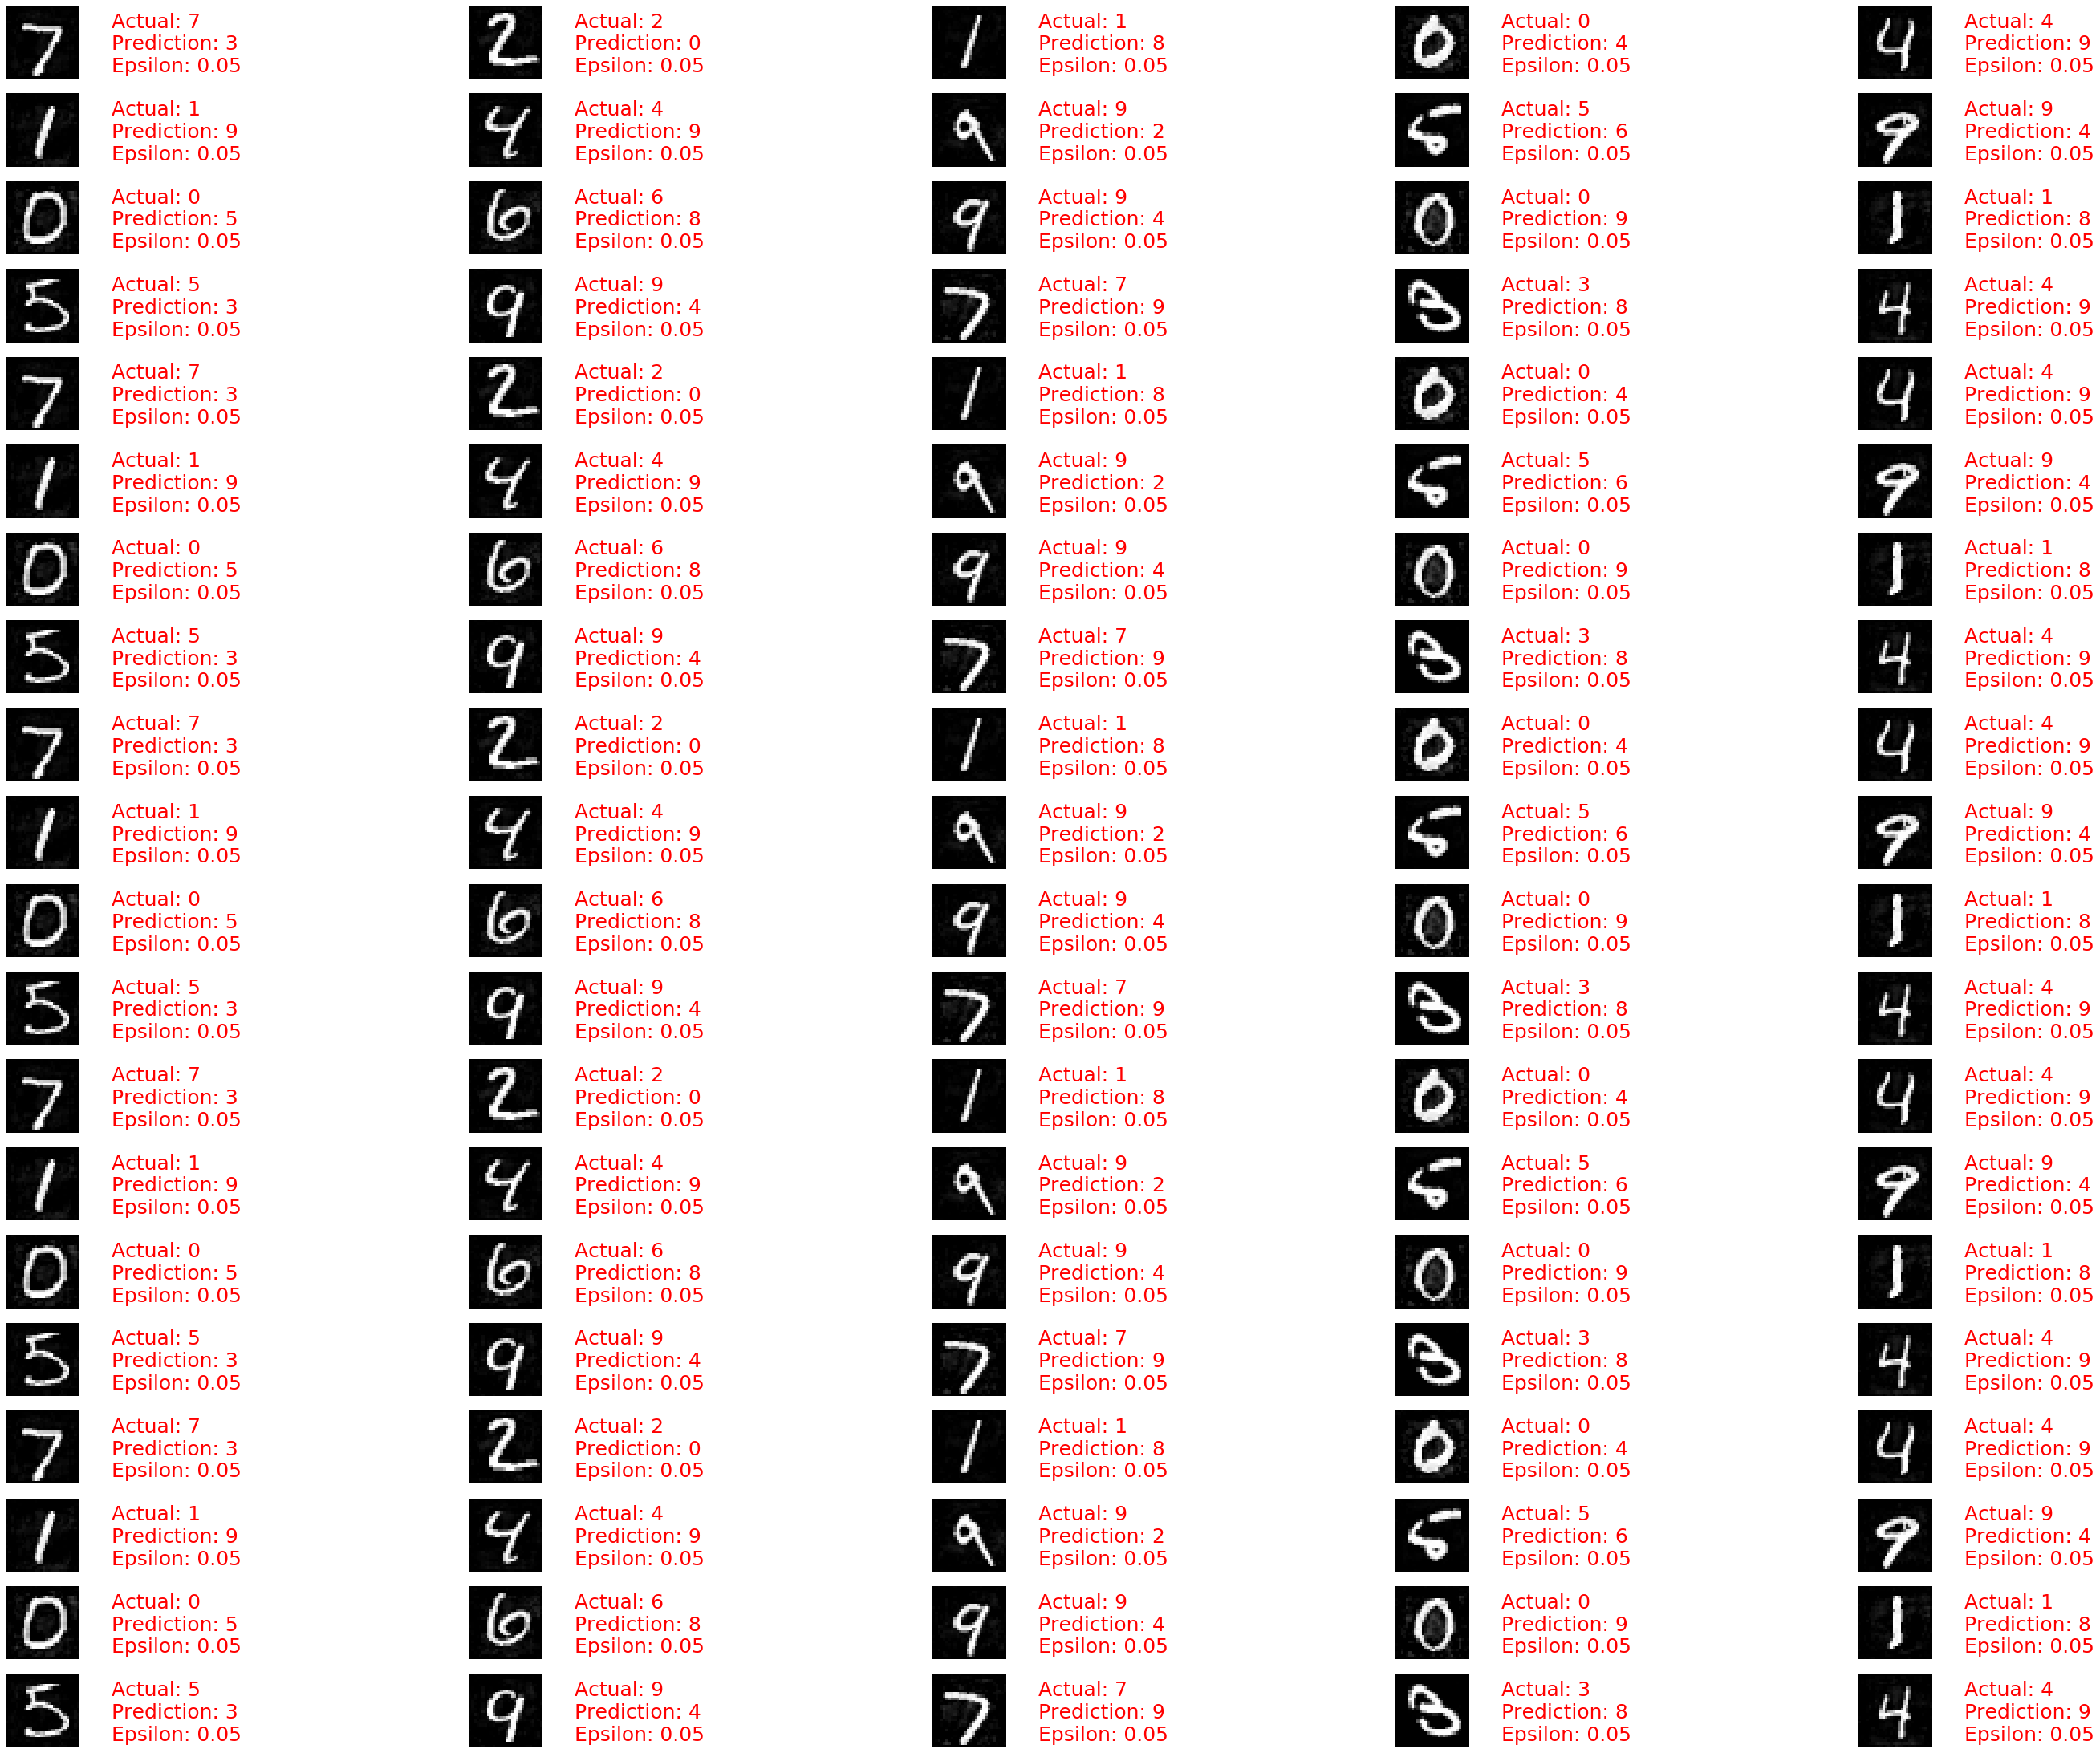

In [22]:
L2_and_plot(0,2)

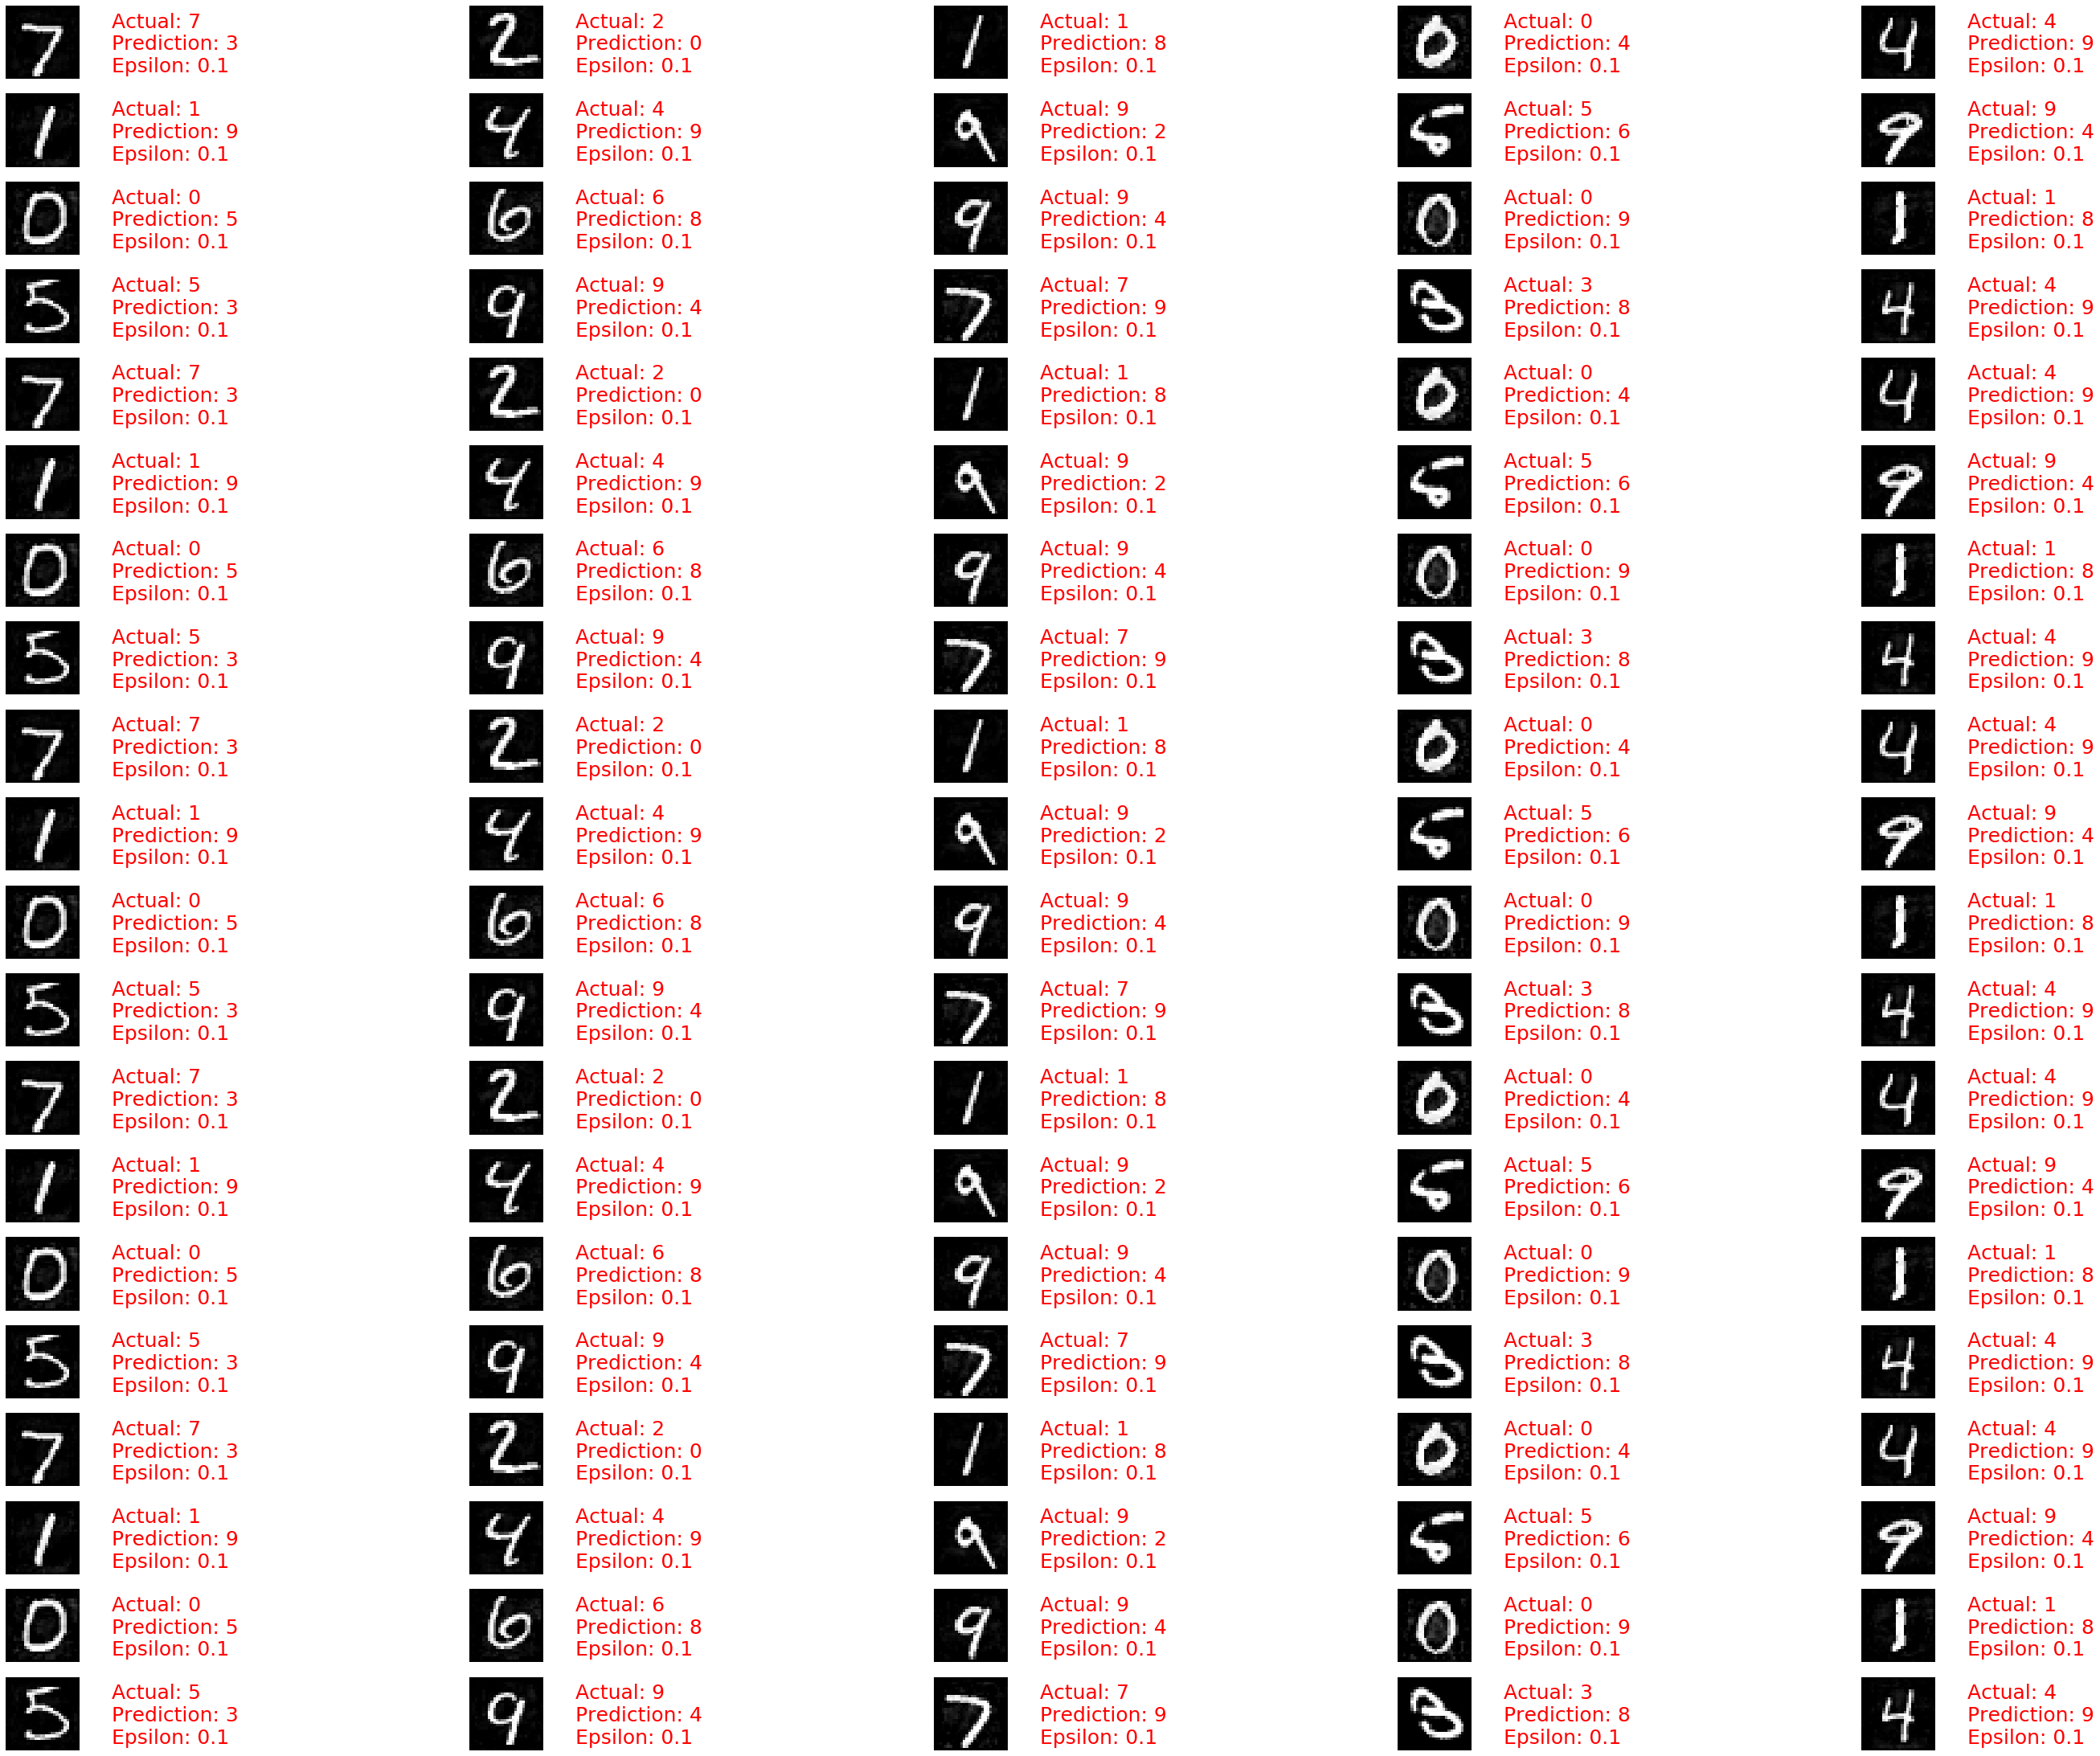

In [23]:
L2_and_plot(0,3)

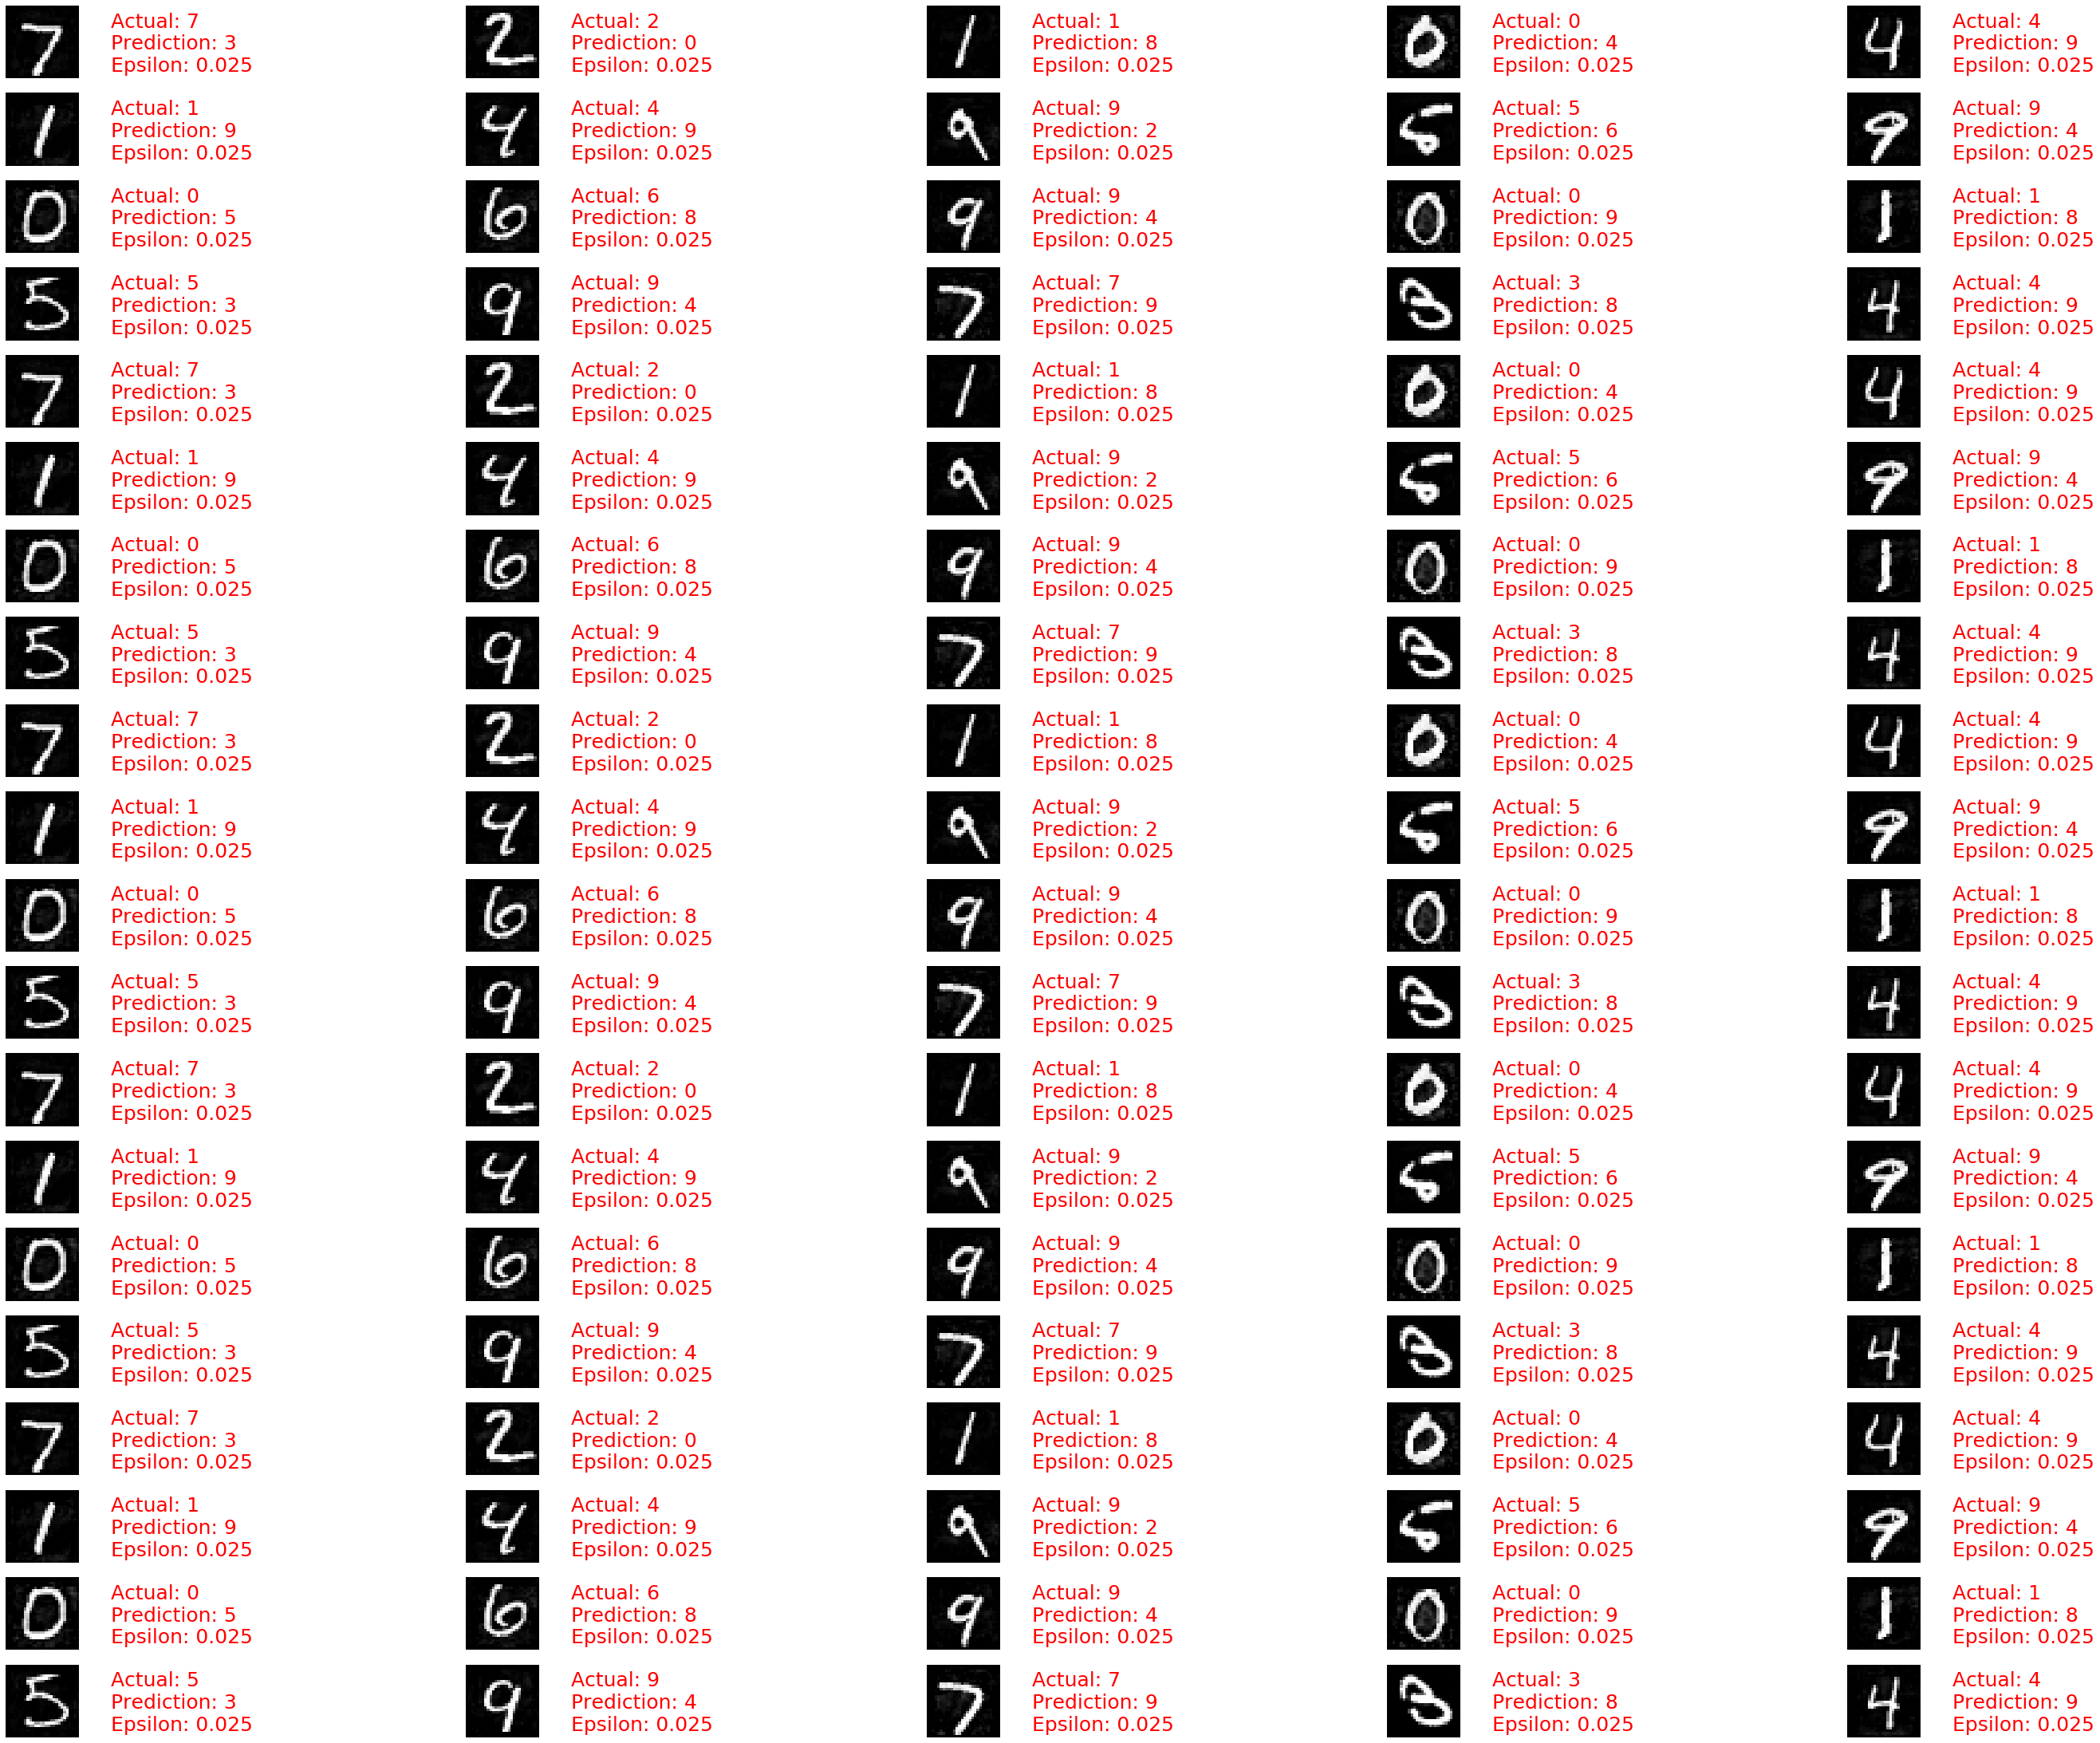

In [24]:
L2_and_plot(1,1)

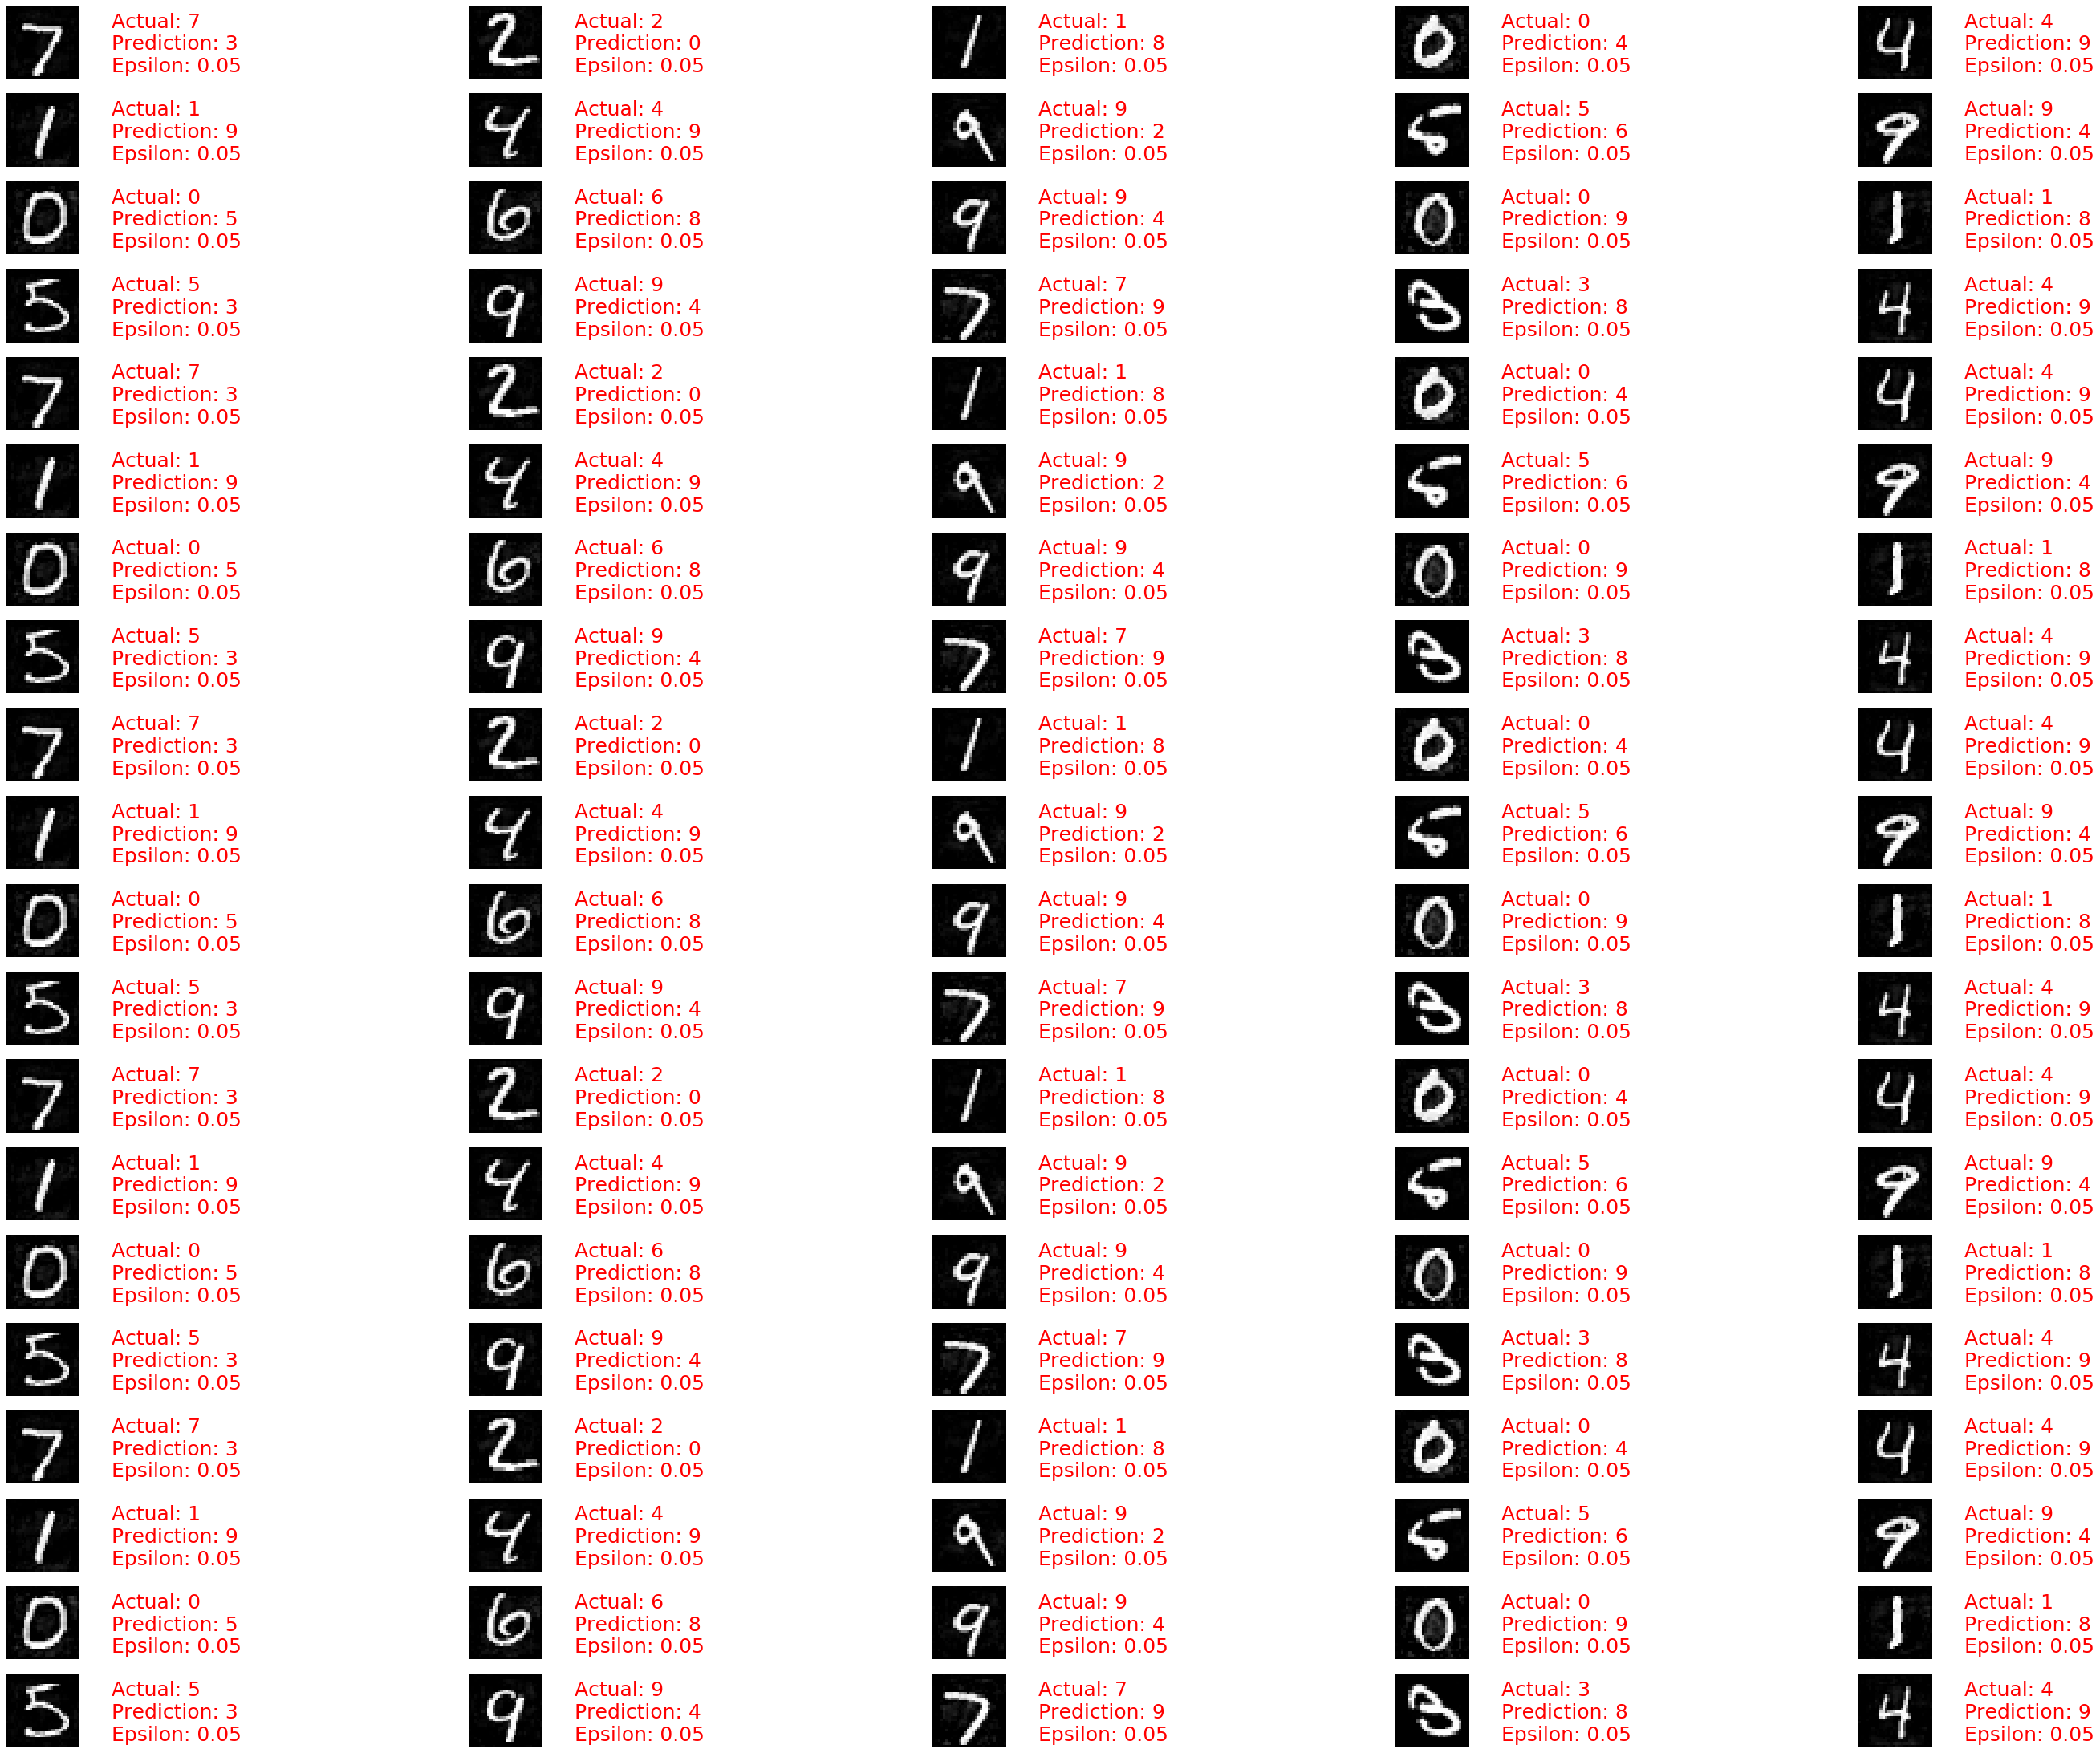

In [25]:
L2_and_plot(1,2)

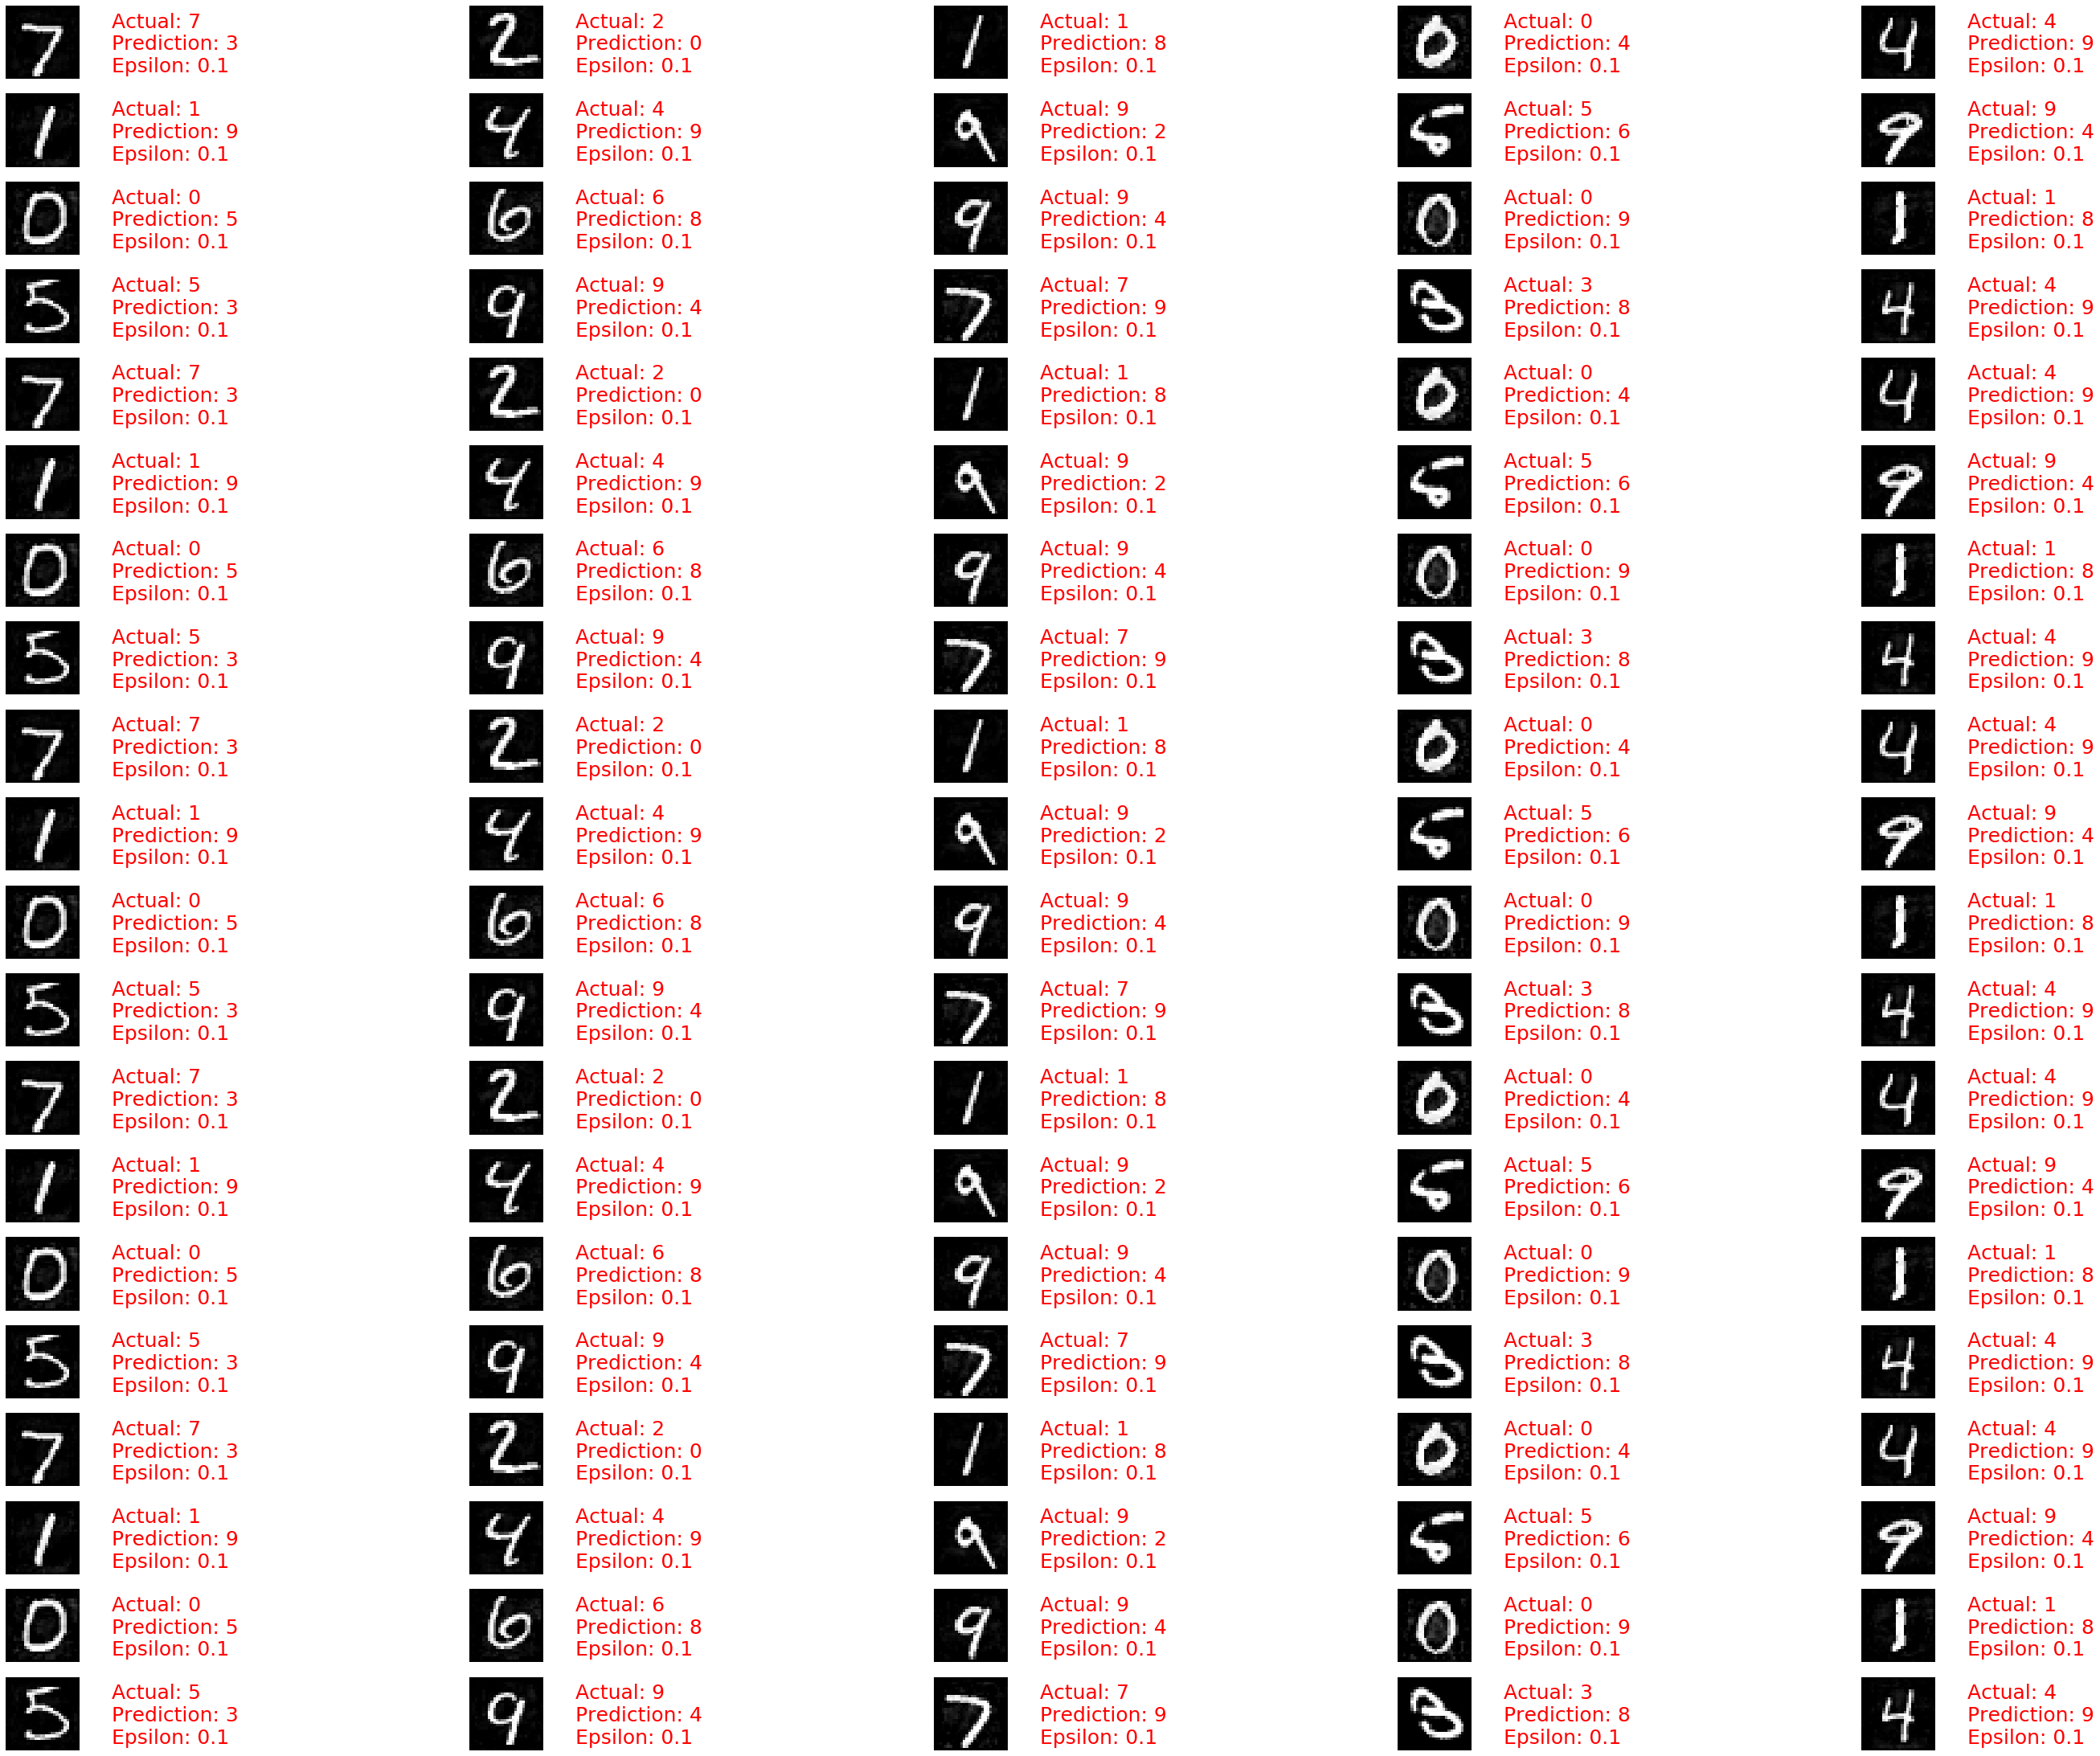

In [26]:
L2_and_plot(1,3)

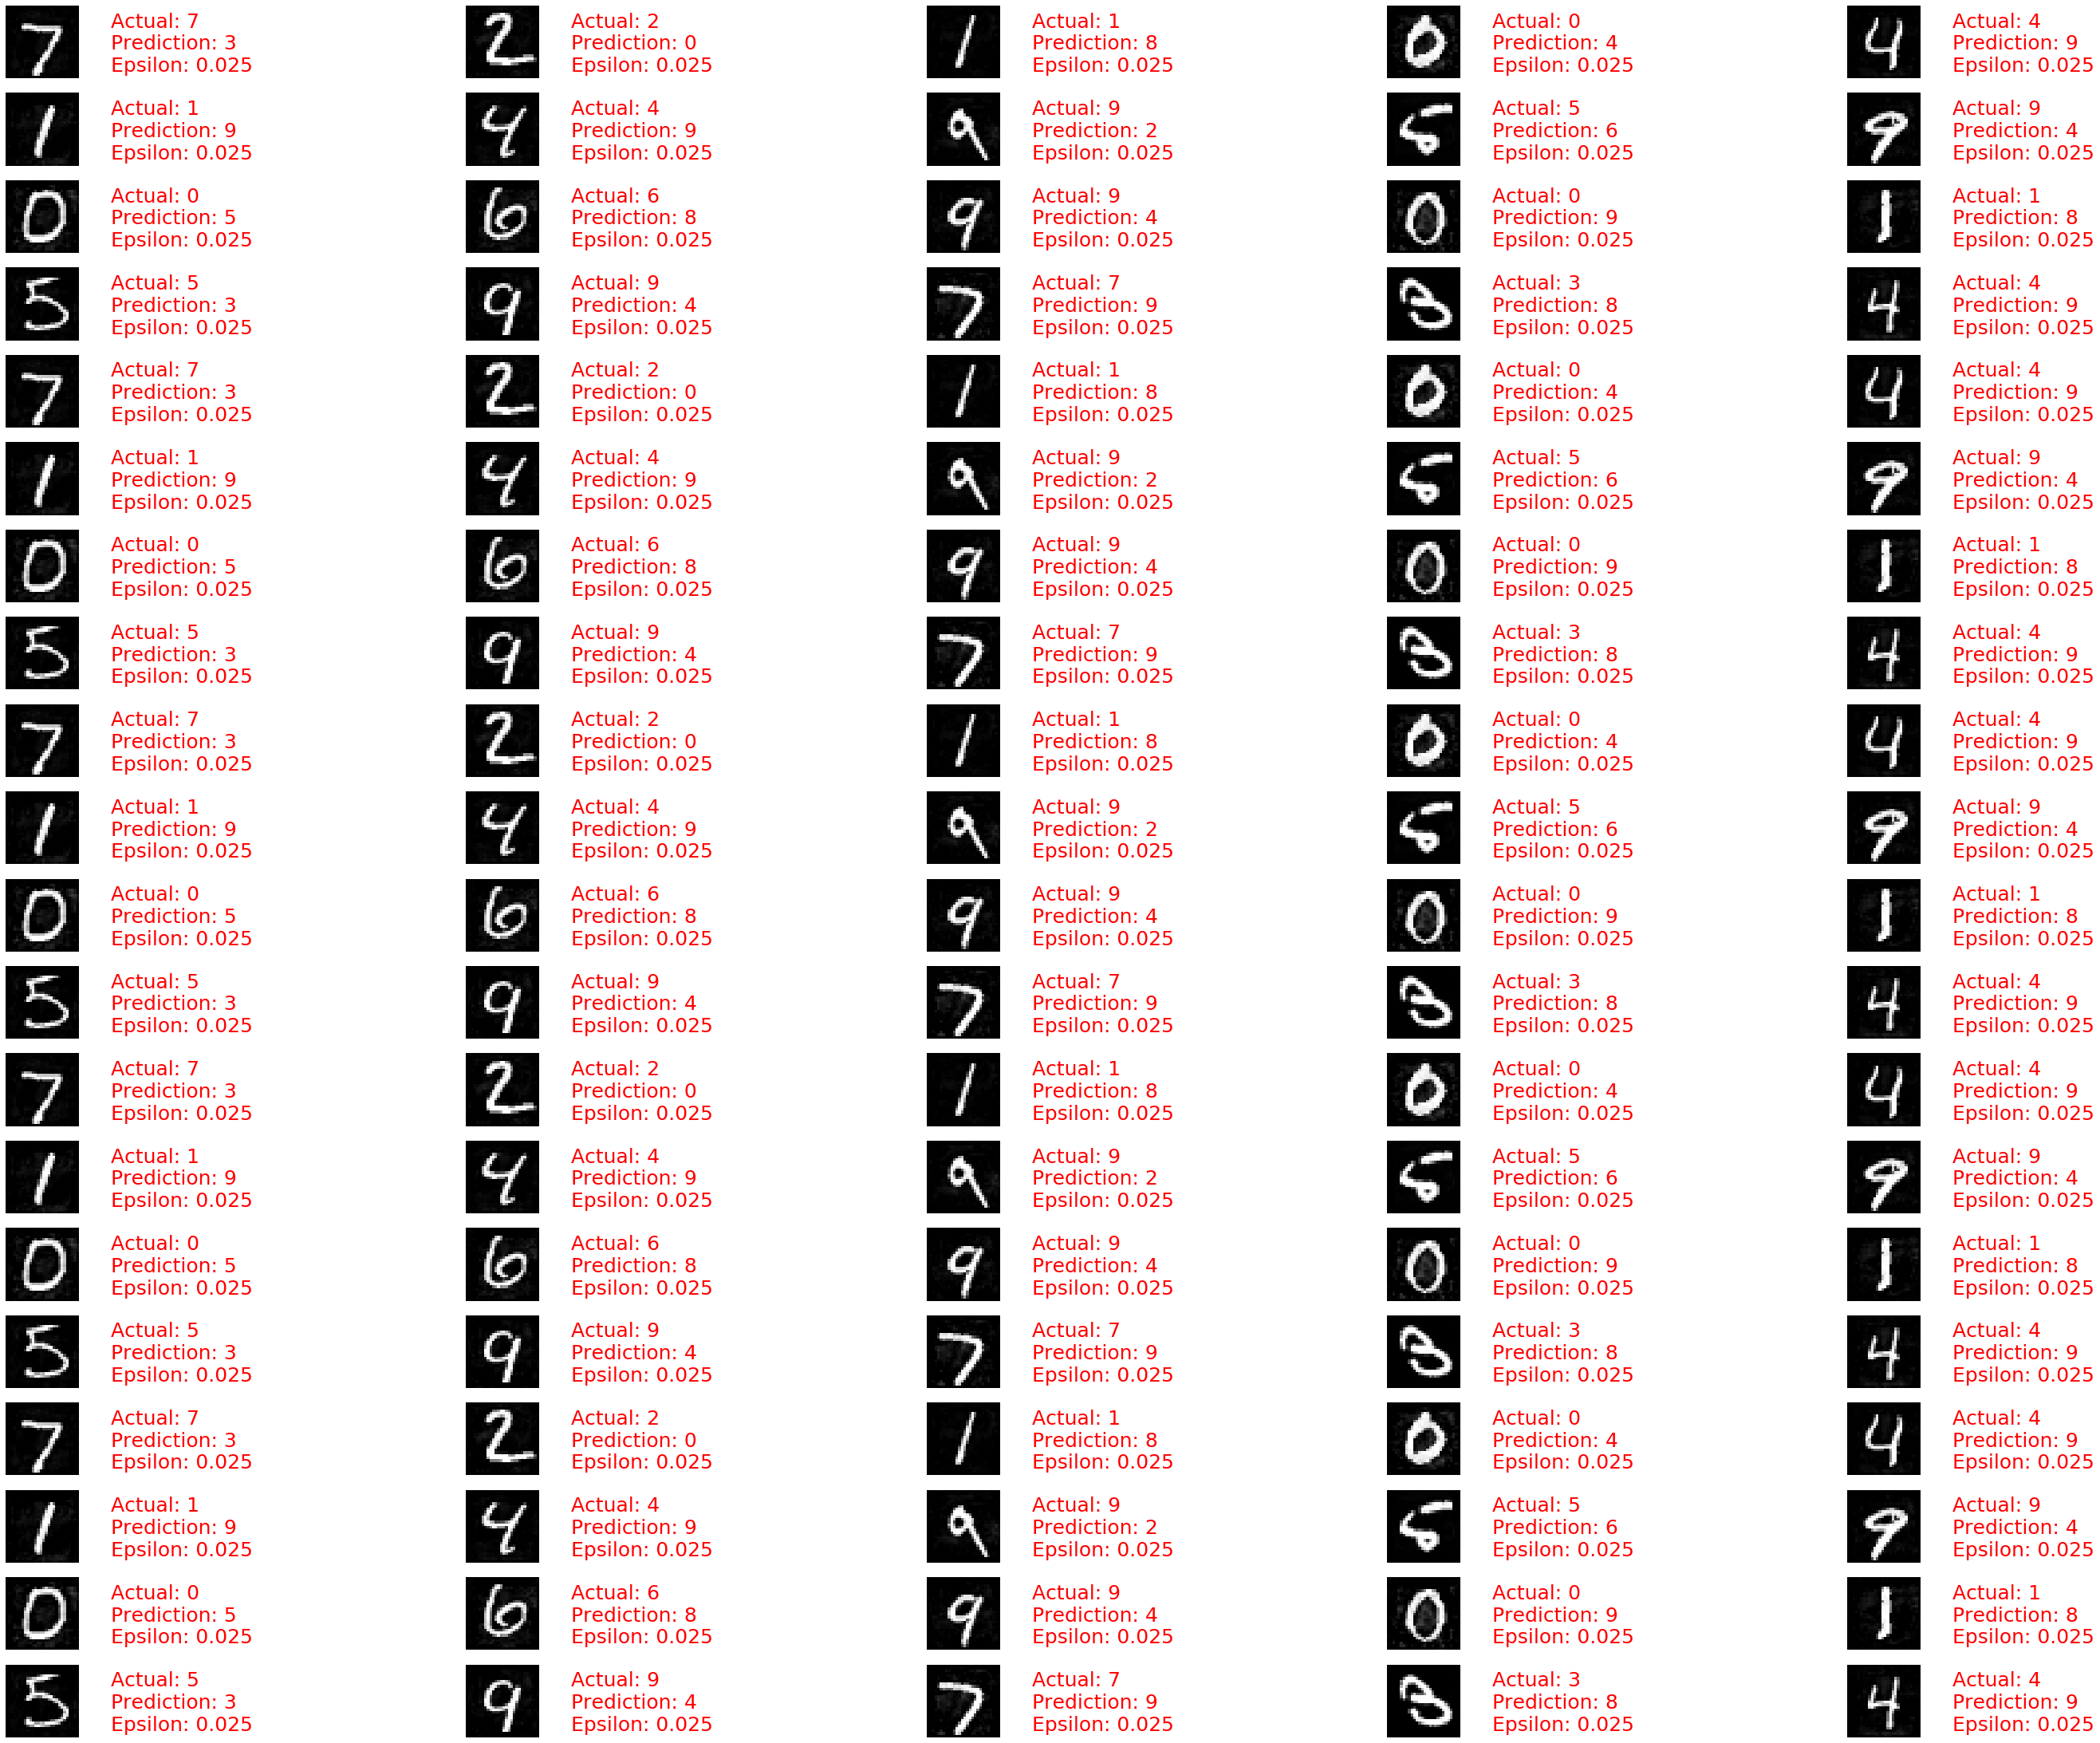

In [27]:
L2_and_plot(2,1)

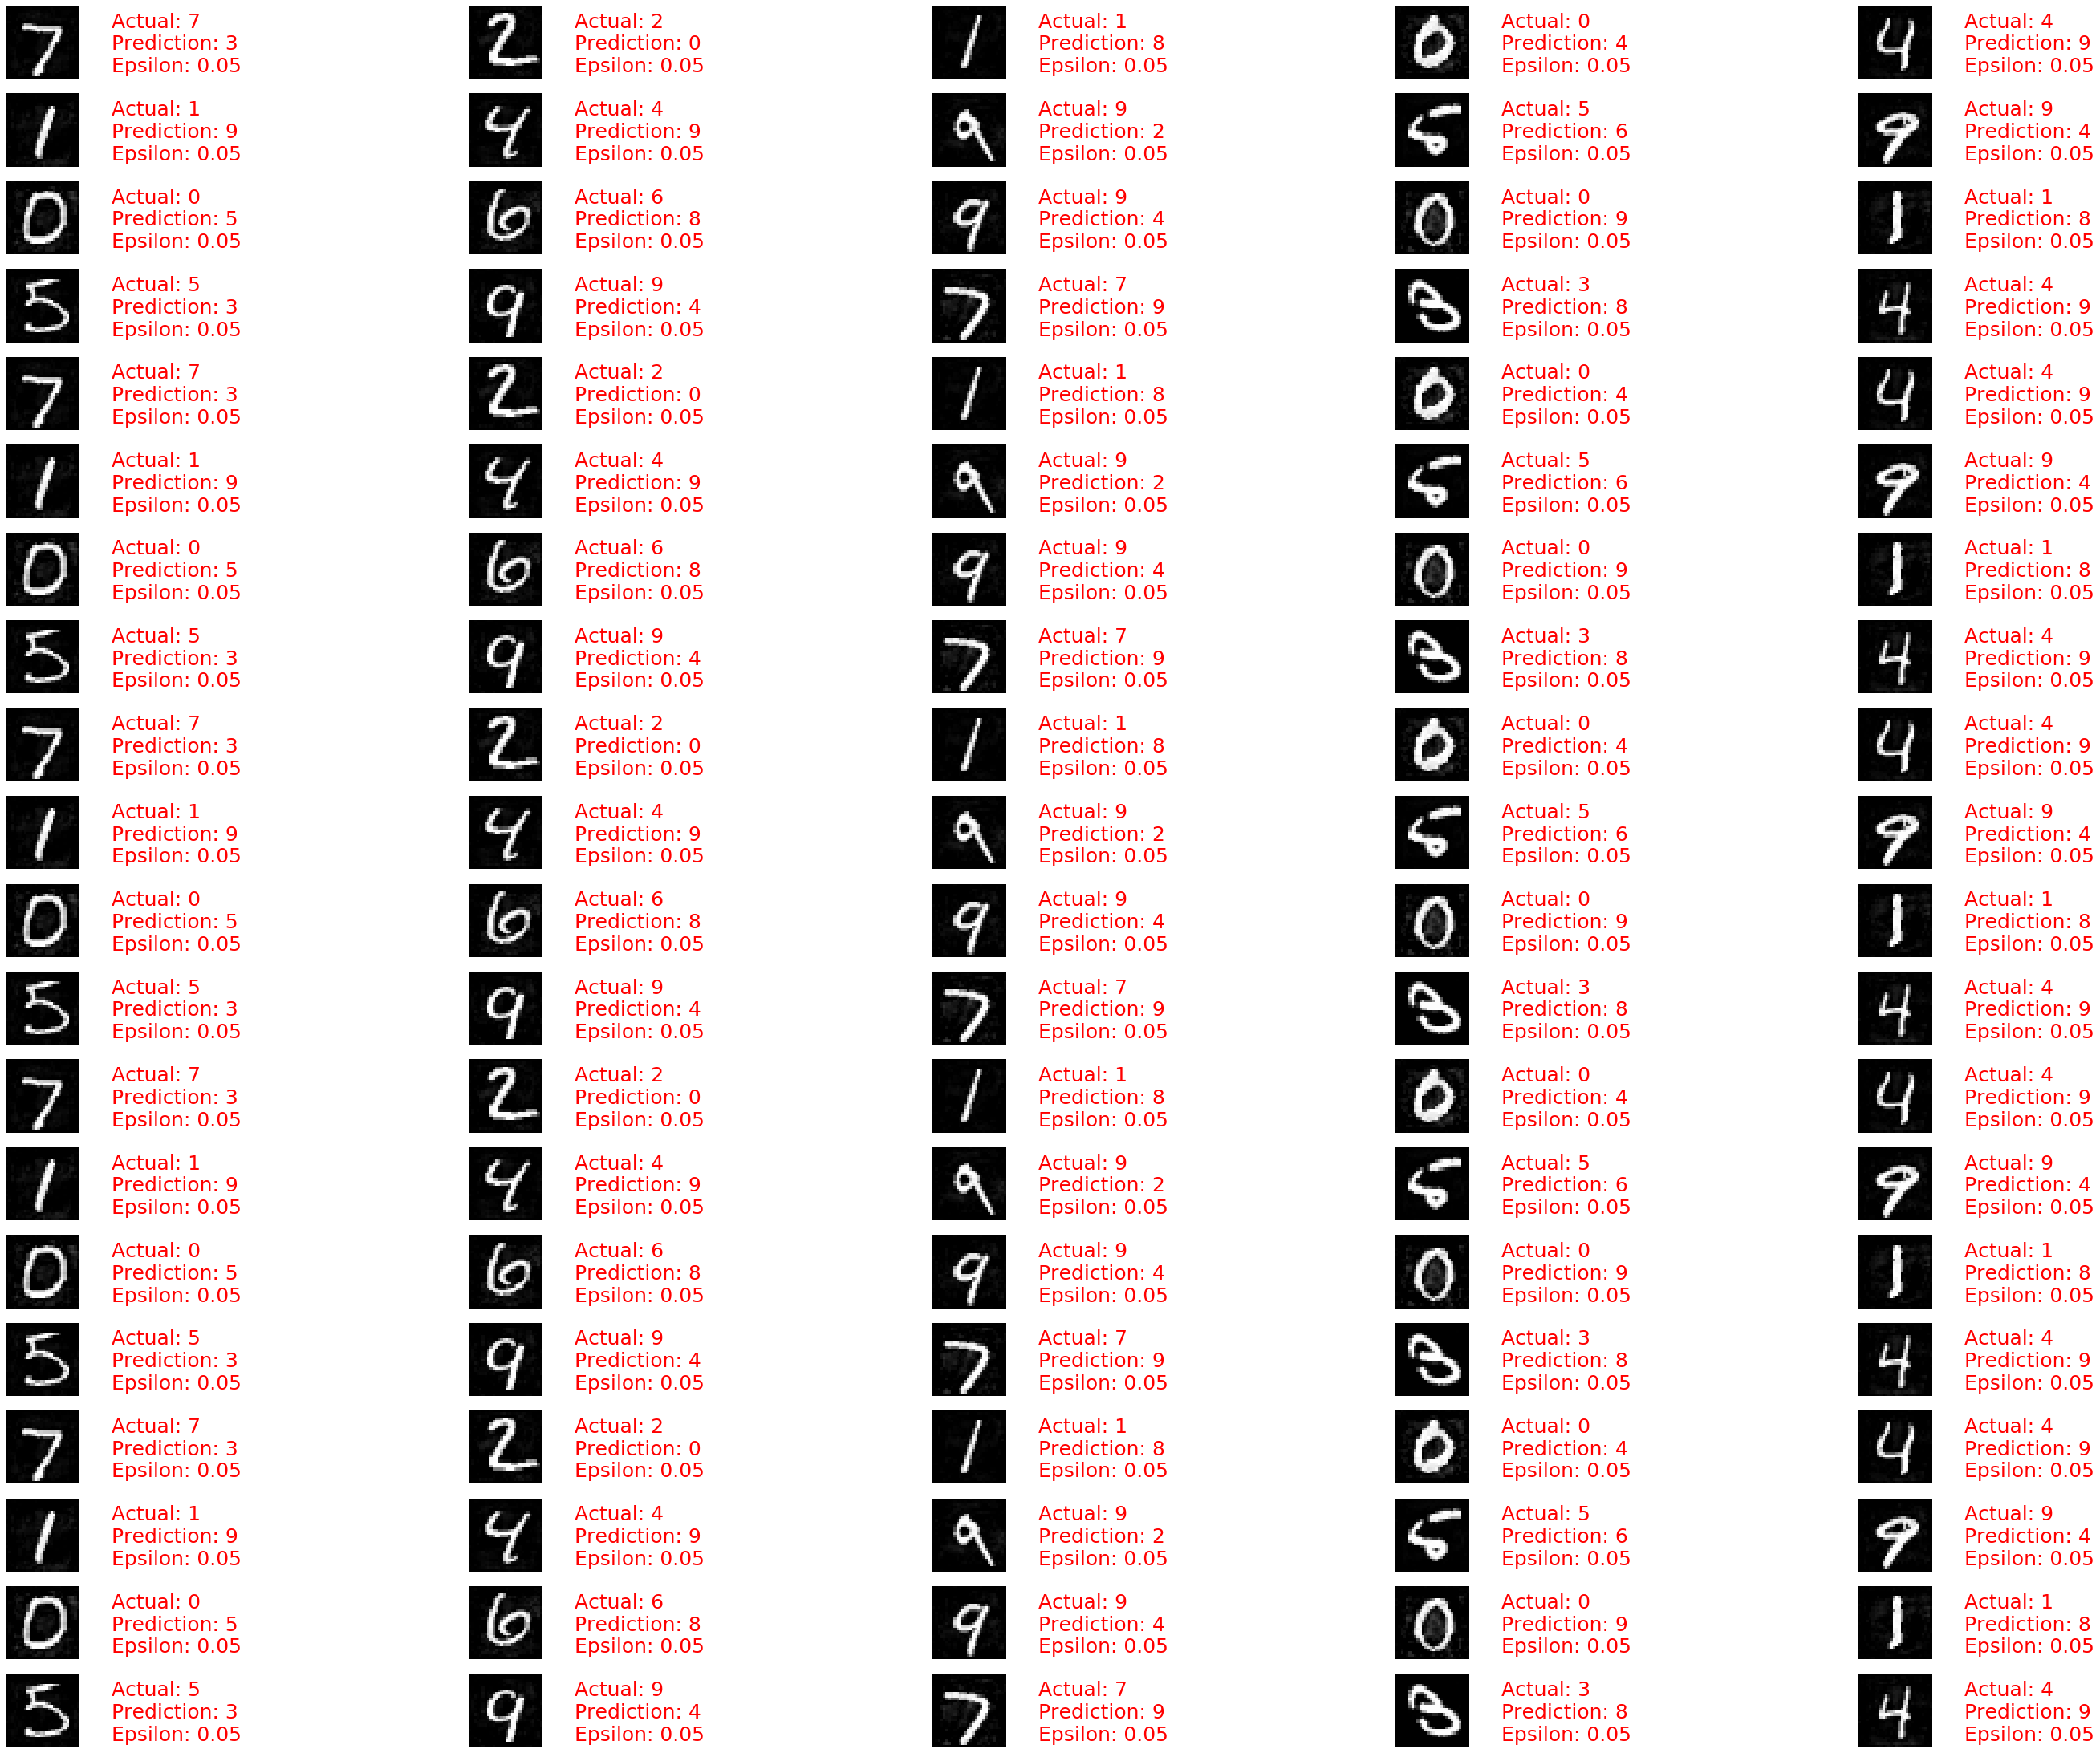

In [28]:
L2_and_plot(2,2)

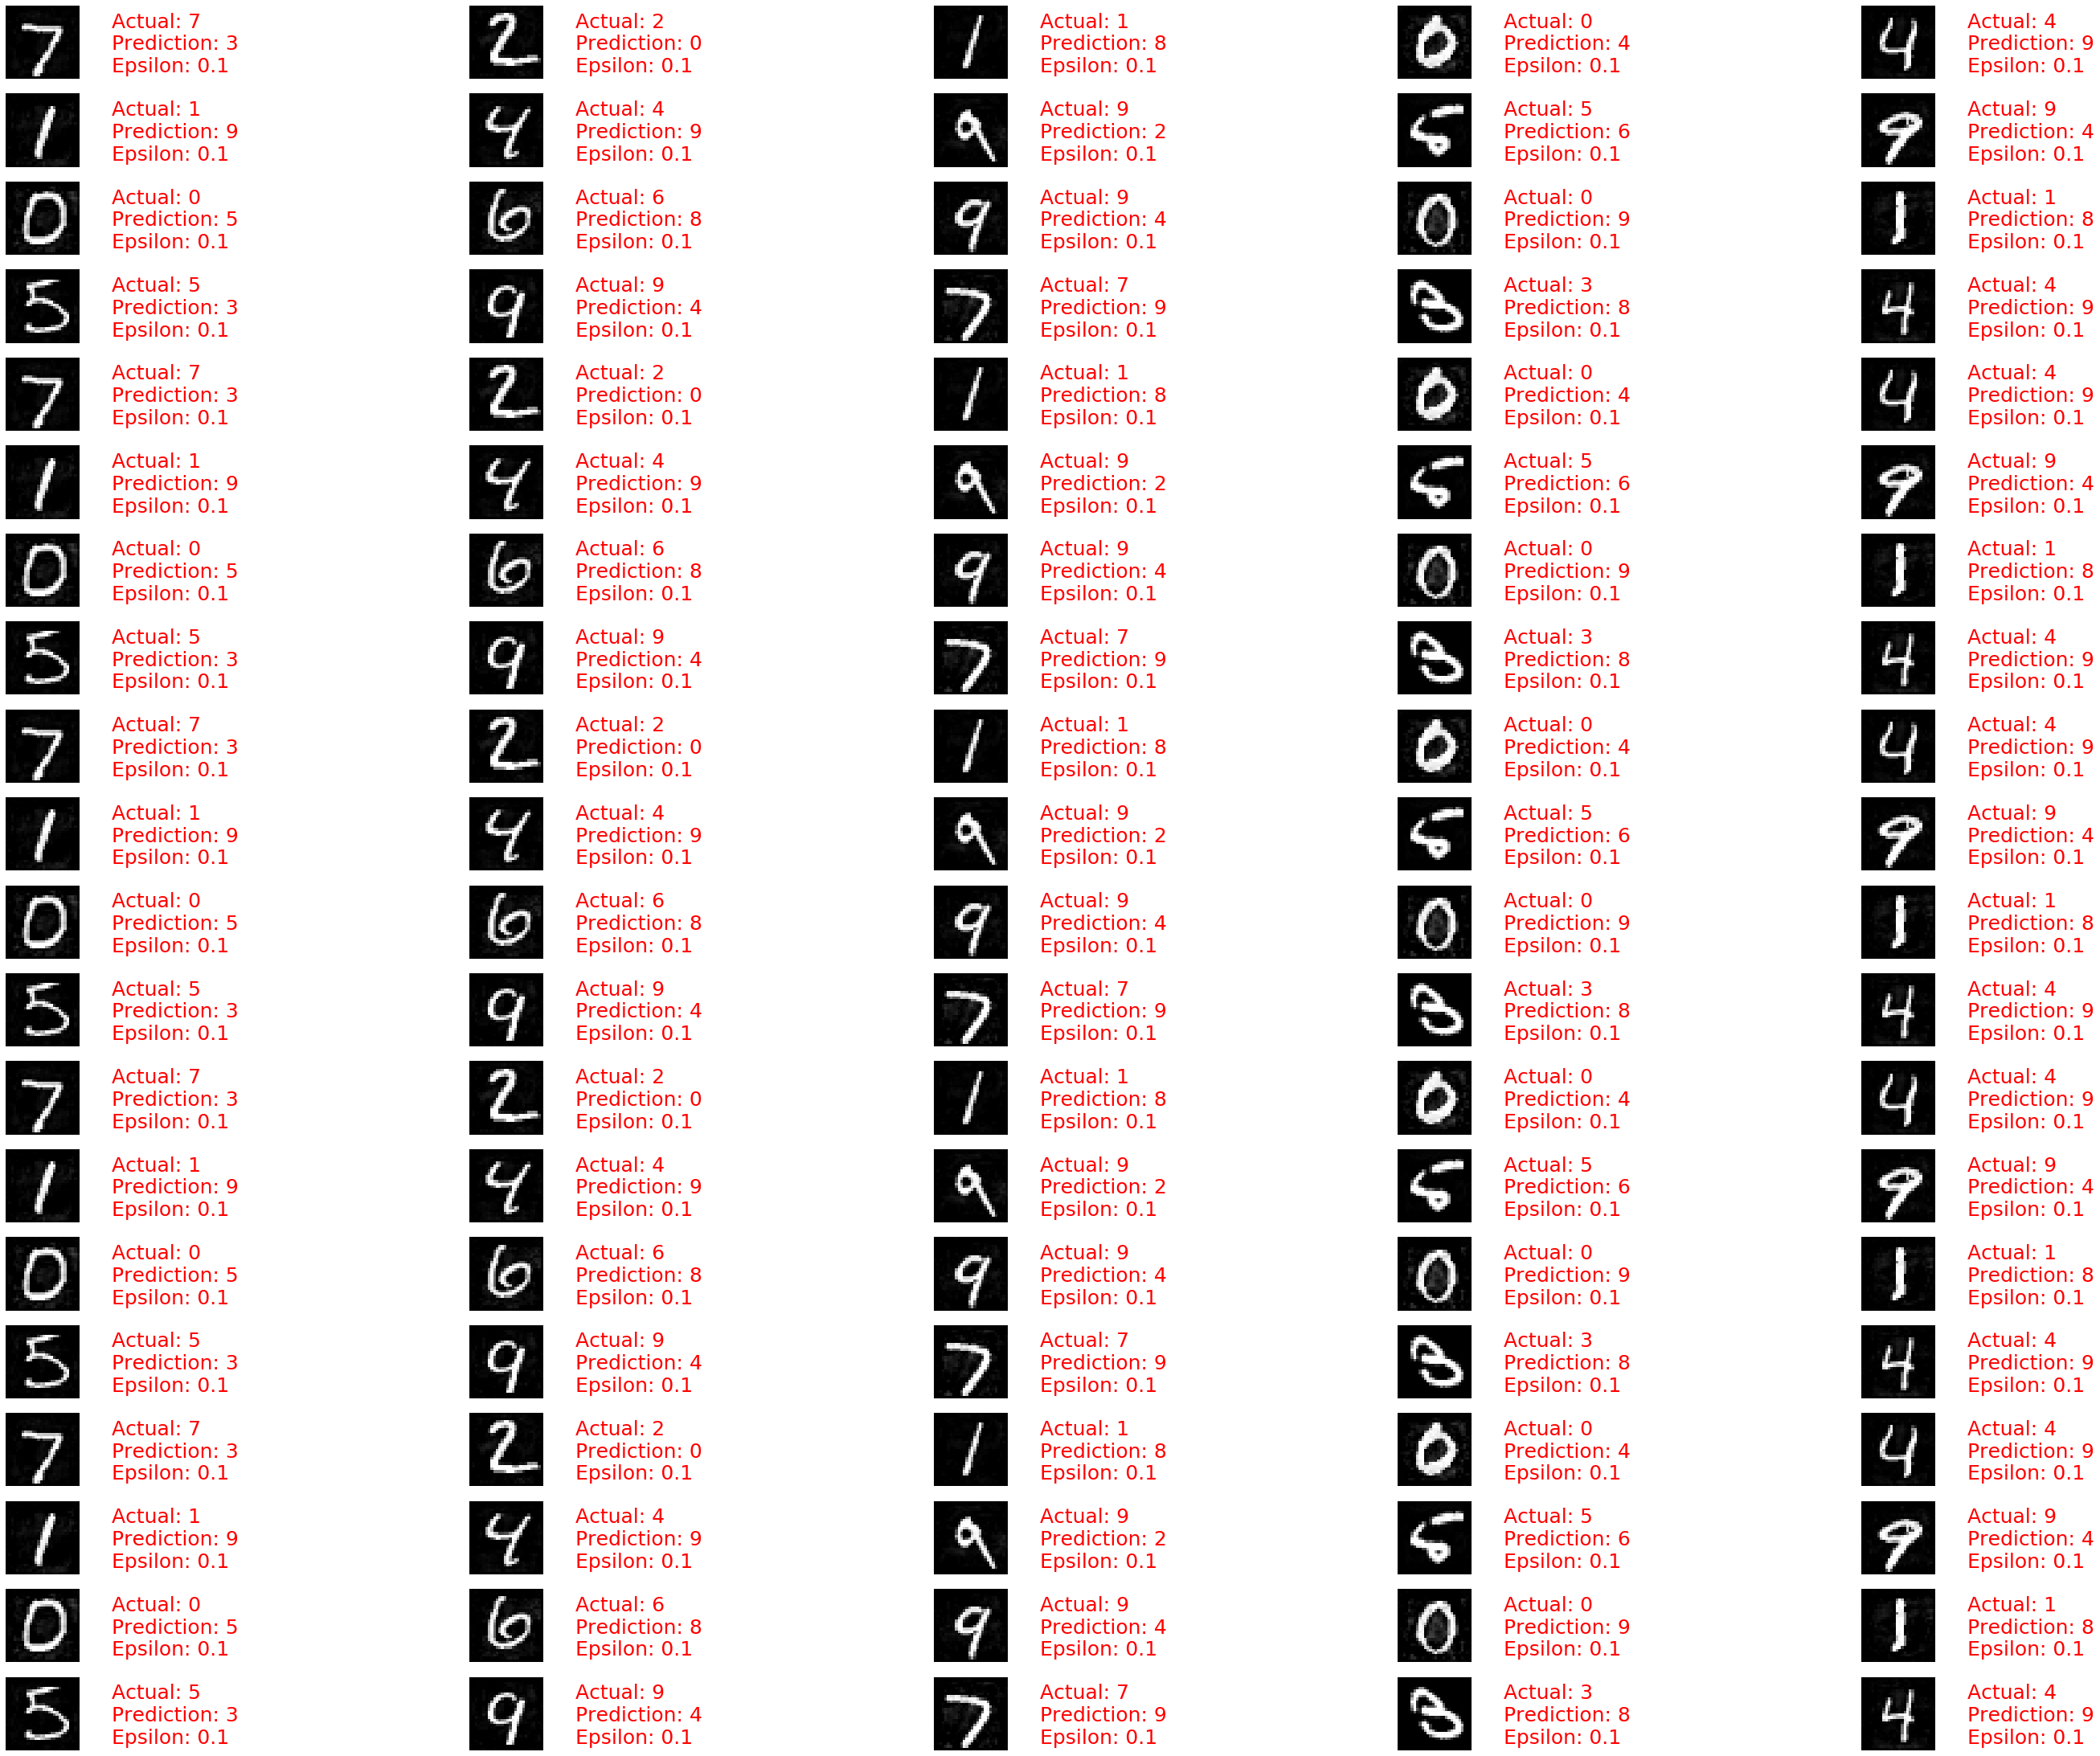

In [29]:
L2_and_plot(2,3)

In [30]:
L2_Arr = np.array(L2).reshape((3,3))

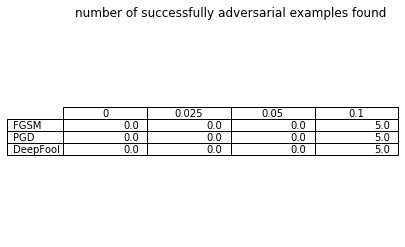

In [31]:
plt.axis("off")
plt.title("number of successfully adversarial examples found")
plt.table(cellText=(success_adv*100).round(),rowLabels=("FGSM","PGD","DeepFool"),colLabels=("0", "0.025", "0.05", "0.1"),loc='center')
plt.show()

In [32]:
#This is to calculate the average time
#avgFGSM = time_of_attack[0]/sum(totsuccess[0])
#avgPGD = time_of_attack[1]/sum(totsuccess[1])
#avgDF = time_of_attack[2]/sum(totsuccess[2])
#print("Average Time to find a FGSM adversial example:", avgFGSM)
#print("Average Time to find a PGD adversial example:", avgPGD)
#print("Average Time to find a DF adversial example:", avgDF)

In [33]:
#print("L2 avgs for each eps value PGD: ", individualL2[0])
#print("L2 avgs for each eps value FGSM: ", individualL2[1])
#print("L2 avgs for each eps value DF: ", individualL2[2])

In [34]:
#x = PrettyTable()
#x.field_names = ['Attack', 'Average time to find Adversarial Ex']
#x.add_row(['FGSM:', avgFGSM])
#x.add_row(['PGD:', avgPGD])
#x.add_row(['DeepFool:', avgDF])

In [35]:
#y = PrettyTable()
#y.field_names = ['Attacks', 'Epsilon 0', 'Epsilon 0.001', 'Epsilon 0.005', 'Epsilon 0.01', 'Epsilon 0.01', 'Epsilon 0.03', 'Epsilon 0.1', 'Epsilon 0.5', 'Epsilon 1.0']
#y.add_row(['PGD: Advs Ex Found', listsuccessPGD[0], listsuccessPGD[1], listsuccessPGD[2], listsuccessPGD[3], listsuccessPGD[4], listsuccessPGD[5], listsuccessPGD[6], listsuccessPGD[7]])
#y.add_row(['FGSM: Advs Ex Found', listsuccessFGSM[0], listsuccessFGSM[1], listsuccessFGSM[2], listsuccessFGSM[3], listsuccessFGSM[4], listsuccessFGSM[5], listsuccessFGSM[6], listsuccessFGSM[7]])
#y.add_row(['DeepFool: Advs Ex Found', listsuccessDF[0], listsuccessDF[1], listsuccessDF[2], listsuccessDF[3], listsuccessDF[4], listsuccessDF[5], listsuccessDF[6], listsuccessDF[7]])

#y.add_row(['PGD: L2 average', finallistl2PGD[0], finallistl2PGD[1], finallistl2PGD[2], finallistl2PGD[3], finallistl2PGD[4], finallistl2PGD[5], finallistl2PGD[6], finallistl2PGD[7]])
#y.add_row(['FGSM: L2 average', finallistl2FGSM[0], finallistl2FGSM[1], finallistl2FGSM[2], finallistl2FGSM[3], finallistl2FGSM[4], finallistl2FGSM[5], finallistl2FGSM[6], finallistl2FGSM[7]])
#y.add_row(['DeepFool: L2 average', finallistl2Df[0], finallistl2Df[1], finallistl2Df[2], finallistl2Df[3], finallistl2Df[4], finallistl2Df[5], finallistl2Df[6], finallistl2Df[7]])
